# PE4MOVE Data Analysis

This notebook analyzes the PE4MOVE dataset containing Physical Activity results and related parameters.

## Research Questions
- Was the PE4MOVE program successful?
- Which parameters influence the success of the study?
- What kind of children could improve the most from the program?

## Data Exploration

We'll start by loading the dataset and performing exploratory data analysis (EDA) to understand:
1. **Dataset structure**: Number of rows, columns, and data types
2. **Data quality**: Missing values, duplicates, and outliers
3. **Statistical overview**: Descriptive statistics for key variables
4. **Variable relationships**: Correlations and patterns in the data

This exploration will help us understand the data before addressing our research questions about the PE4MOVE program's effectiveness.

### 1. Import Required Libraries

First, we'll import all necessary libraries for data analysis and visualization:
- **pandas**: For data manipulation and analysis
- **numpy**: For numerical operations
- **matplotlib & seaborn**: For creating visualizations
- **scipy**: For statistical tests

In [1]:
# Import required libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")


### 2. Load Dataset and Variable Legends

We'll load both the main PE4MOVE dataset and the legends file to understand variable meanings and coding schemes.
This dataset contains information about children who participated in the PE4MOVE program, including their physical measurements and 6MWT results before and after the intervention.

In [2]:
# Configure display and plotting settings
df = pd.read_csv('data/PE4MOVE_6MWT.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Columns: 381 entries, Age to Dominant_Hand_T1
dtypes: float64(185), int64(188), object(8)
memory usage: 9.3+ MB


### 3. Dataset Overview and Quality Assessment

Let's examine the basic structure and quality of our dataset.

In [3]:
# === COMPREHENSIVE DATASET OVERVIEW ===

print("=== BASIC DATASET INFORMATION ===")
print(f"Participants: {len(df):,}")
print(f"Variables: {df.shape[1]}")
print(f"Age range: {df['Age'].min()} - {df['Age'].max()} years (Mean: {df['Age'].mean():.1f})")

# Gender distribution with proper coding (1=Male, 2=Female based on legends)
sex_counts = df['Sex'].value_counts().sort_index()
print(f"Gender: {sex_counts[1]} males ({sex_counts[1]/len(df)*100:.1f}%), {sex_counts[2]} females ({sex_counts[2]/len(df)*100:.1f}%)")

print(f"\n=== LONGITUDINAL STRUCTURE ===")
t0_cols = [col for col in df.columns if '_T0' in col]
t1_cols = [col for col in df.columns if '_T1' in col]
print(f"Baseline (T0) variables: {len(t0_cols)}")
print(f"Follow-up (T1) variables: {len(t1_cols)}")

print(f"\n=== DATA QUALITY ASSESSMENT ===")
# Categorize variables by missing data
missing_summary = df.isnull().sum()
excellent = (missing_summary == 0).sum()
good = ((missing_summary > 0) & (missing_summary <= len(df) * 0.05)).sum()
fair = ((missing_summary > len(df) * 0.05) & (missing_summary <= len(df) * 0.20)).sum()
poor = (missing_summary > len(df) * 0.20).sum()

print(f"Excellent (0% missing): {excellent} variables")
print(f"Good (≤5% missing): {good} variables") 
print(f"Fair (5-20% missing): {fair} variables")
print(f"Poor (>20% missing): {poor} variables")

print(f"\n=== KEY VARIABLE CATEGORIES ===")
# Identify important variable types
mvpa_vars = [col for col in df.columns if 'MVPA' in col]
physical_vars = [col for col in df.columns if any(term in col.lower() for term in ['weight', 'height', 'bmi', 'jump', 'grip'])]
demographic_vars = ['Age', 'Sex'] + [col for col in df.columns if any(term in col.lower() for term in ['country', 'birth'])]

print(f"Physical Activity (MVPA): {len(mvpa_vars)} variables")
print(f"Physical Measures: {len(physical_vars)} variables")
print(f"Demographics: {len(demographic_vars)} variables")

# Show first few rows
print(f"\n=== SAMPLE DATA ===")
display(df[['Age', 'Sex', 'MVPA_Frequency_T0', 'Weight_kg_T0', 'Height_cm_T0']].head())

=== BASIC DATASET INFORMATION ===
Participants: 3,193
Variables: 381
Age range: 11 - 18 years (Mean: 13.8)
Gender: 1535 males (48.1%), 1658 females (51.9%)

=== LONGITUDINAL STRUCTURE ===
Baseline (T0) variables: 175
Follow-up (T1) variables: 175

=== DATA QUALITY ASSESSMENT ===
Excellent (0% missing): 190 variables
Good (≤5% missing): 2 variables
Fair (5-20% missing): 4 variables
Poor (>20% missing): 185 variables

=== KEY VARIABLE CATEGORIES ===
Physical Activity (MVPA): 13 variables
Physical Measures: 4 variables
Demographics: 6 variables

=== SAMPLE DATA ===


,Age,Sex,MVPA_Frequency_T0,Weight_kg_T0,Height_cm_T0
0,11,2,3,39,155
1,11,2,6,30,140
2,11,2,1,45,145
3,11,2,2,32,139
4,11,2,1,65,151


Let's examine the variables and their relationships

_maybe implement the split of df here?_

In [4]:
# === COMPREHENSIVE VARIABLE OVERVIEW ===
print("="*80)
print("COMPLETE VARIABLE INVENTORY - PE4MOVE DATASET")
print("="*80)

print(f"TOTAL VARIABLES: {len(df.columns)}")
print(f"TOTAL PARTICIPANTS: {len(df):,}")
# Categorize variables by type and timepoint
print(f"\nVARIABLE CATEGORIES:")

# 1. Demographic and Basic Info
demographic_vars = []
for col in df.columns:
    if any(term in col.lower() for term in ['age', 'sex', 'birth', 'country', 'id', 'code']):
        demographic_vars.append(col)

print(f"\n DEMOGRAPHIC VARIABLES ({len(demographic_vars)}):")
for var in sorted(demographic_vars):
    non_null = df[var].count()
    print(f"   • {var:<30} ({non_null:,}/{len(df):,} complete)")

# 2. Physical Activity Variables
mvpa_vars = []
exercise_vars = []
for col in df.columns:
    if 'mvpa' in col.lower():
        mvpa_vars.append(col)
    elif any(term in col.lower() for term in ['exercise', 'leisure', 'sport']):
        exercise_vars.append(col)

print(f"\n PHYSICAL ACTIVITY VARIABLES:")
print(f"   MVPA Variables ({len(mvpa_vars)}):")
for var in sorted(mvpa_vars)[:10]:  # Show first 10
    non_null = df[var].count()
    print(f"      • {var:<35} ({non_null:,}/{len(df):,} complete)")
if len(mvpa_vars) > 10:
    print(f"      ... and {len(mvpa_vars)-10} more MVPA variables")

print(f"\n   Exercise/Sport Variables ({len(exercise_vars)}):")
for var in sorted(exercise_vars)[:8]:  # Show first 8
    non_null = df[var].count()
    print(f"      • {var:<35} ({non_null:,}/{len(df):,} complete)")
if len(exercise_vars) > 8:
    print(f"      ... and {len(exercise_vars)-8} more exercise variables")

# 3. Anthropometric/Physical Measurements
anthro_vars = []
for col in df.columns:
    if any(term in col.lower() for term in ['weight', 'height', 'bmi', 'cm', 'kg']):
        anthro_vars.append(col)

print(f"\n ANTHROPOMETRIC VARIABLES ({len(anthro_vars)}):")
for var in sorted(anthro_vars):
    non_null = df[var].count()
    print(f"   • {var:<30} ({non_null:,}/{len(df):,} complete)")

# 4. Physical Performance Tests
performance_vars = []
for col in df.columns:
    if any(term in col.lower() for term in ['jump', 'slj', 'grip', 'hg', 'strength', 'test', '6mw', 'walk']):
        performance_vars.append(col)

print(f"\n PHYSICAL PERFORMANCE TESTS ({len(performance_vars)}):")
for var in sorted(performance_vars)[:12]:  # Show first 12
    non_null = df[var].count()
    print(f"   • {var:<35} ({non_null:,}/{len(df):,} complete)")
if len(performance_vars) > 12:
    print(f"   ... and {len(performance_vars)-12} more performance variables")

# 5. School/Educational Variables
school_vars = []
for col in df.columns:
    if any(term in col.lower() for term in ['school', 'grade', 'class', 'education']):
        school_vars.append(col)

if school_vars:
    print(f"\n SCHOOL-RELATED VARIABLES ({len(school_vars)}):")
    for var in sorted(school_vars):
        non_null = df[var].count()
        print(f"   • {var:<30} ({non_null:,}/{len(df):,} complete)")

# 6. Timepoint Analysis (T0 vs T1)
t0_vars = [col for col in df.columns if '_T0' in col]
t1_vars = [col for col in df.columns if '_T1' in col]

print(f"\n LONGITUDINAL STRUCTURE:")
print(f"  Baseline (T0) Variables: {len(t0_vars)}")
print(f"  Follow-up (T1) Variables: {len(t1_vars)}")

# Find matched pairs
matched_pairs = []
for t0_var in t0_vars:
    t1_var = t0_var.replace('_T0', '_T1')
    if t1_var in df.columns:
        matched_pairs.append((t0_var, t1_var))

print(f"  Matched T0/T1 Pairs: {len(matched_pairs)}")

# 7. Data Quality by Category
print(f"\n DATA COMPLETENESS BY CATEGORY:")

categories = {
    'Demographics': demographic_vars,
    'MVPA': mvpa_vars[:10],  # Sample for display
    'Anthropometric': anthro_vars,
    'Performance Tests': performance_vars[:10],  # Sample for display
    'School': school_vars
}

for cat_name, cat_vars in categories.items():
    if cat_vars:
        completeness_rates = [df[var].count()/len(df)*100 for var in cat_vars]
        avg_completeness = np.mean(completeness_rates)
        print(f"   {cat_name:<15}: {avg_completeness:5.1f}% average completeness")

# 8. Key Variables for Research Questions
print(f"\n KEY VARIABLES FOR RESEARCH QUESTIONS:")

key_outcome_vars = []
key_predictor_vars = []

# Identify key outcome variables (things that might change due to intervention)
for var in df.columns:
    if any(term in var.lower() for term in ['mvpa_frequency', 'exercise', '6mw', 'jump', 'grip']):
        if '_T0' in var or '_T1' in var:
            key_outcome_vars.append(var)

# Identify key predictor variables (baseline characteristics)
for var in df.columns:
    if var in ['Age', 'Sex'] or any(term in var.lower() for term in ['bmi', 'weight', 'height']):
        if '_T0' in var or var in ['Age', 'Sex']:
            key_predictor_vars.append(var)

print(f"\n   Key Outcome Variables (what might change):")
for var in sorted(set(key_outcome_vars))[:15]:  # Show top 15
    non_null = df[var].count()
    print(f"      • {var:<35} ({non_null:,}/{len(df):,} complete)")

print(f"\n   Key Predictor Variables (baseline characteristics):")
for var in sorted(set(key_predictor_vars)):
    non_null = df[var].count()
    print(f"      • {var:<35} ({non_null:,}/{len(df):,} complete)")


COMPLETE VARIABLE INVENTORY - PE4MOVE DATASET
TOTAL VARIABLES: 381
TOTAL PARTICIPANTS: 3,193

VARIABLE CATEGORIES:

 DEMOGRAPHIC VARIABLES (30):
   • Age                            (3,193/3,193 complete)
   • Birth_Country_T0               (121/3,193 complete)
   • Birth_Country_T1               (74/3,193 complete)
   • Birth_Italy_T0                 (3,193/3,193 complete)
   • Birth_Italy_T1                 (1,769/3,193 complete)
   • COVID_impact_T0                (3,193/3,193 complete)
   • COVID_impact_T1                (1,770/3,193 complete)
   • Climate_Performance_Avoidance1_T1 (1,770/3,193 complete)
   • Climate_Performance_Avoidance_1_T0 (3,193/3,193 complete)
   • Climate_Performance_Avoidance_2_T0 (3,193/3,193 complete)
   • Climate_Performance_Avoidance_2_T1 (1,770/3,193 complete)
   • Climate_Performance_Avoidance_3_T0 (3,193/3,193 complete)
   • Climate_Performance_Avoidance_3_T1 (1,770/3,193 complete)
   • Climate_Performance_Avoidance_4_T0 (3,193/3,193 complete)
   • Cl

_von chat:_

ANALYSIS RECOMMENDATIONS:
   1. Focus on matched T0/T1 pairs for intervention analysis
   2. Use high-completeness variables for main analyses
   3. Consider demographic variables as stratification factors
   4. Explore MVPA daily patterns (d0-d8) for activity insights

In [5]:
# === FOCUSED VARIABLE SUMMARY FOR RESEARCH ===
print("="*70)
print("FOCUSED SUMMARY: MOST IMPORTANT VARIABLES FOR THE RESEARCH")
print("="*70)

# Primary Outcome Variables (what we want to see change)
print("\n PRIMARY OUTCOMES (What PE4MOVE should improve):")
primary_outcomes = {}
if 'MVPA_Frequency_T0' in df.columns and 'MVPA_Frequency_T1' in df.columns:
    primary_outcomes['MVPA Frequency'] = ('MVPA_Frequency_T0', 'MVPA_Frequency_T1')

# Check for 6MWT variables
six_mwt_vars = [col for col in df.columns if '6mw' in col.lower() or 'walk' in col.lower()]
if six_mwt_vars:
    t0_6mwt = [col for col in six_mwt_vars if '_T0' in col]
    t1_6mwt = [col for col in six_mwt_vars if '_T1' in col]
    if t0_6mwt and t1_6mwt:
        primary_outcomes['6-Minute Walk Test'] = (t0_6mwt[0], t1_6mwt[0])

# Physical fitness tests
jump_vars = [col for col in df.columns if 'jump' in col.lower() or 'slj' in col.lower()]
grip_vars = [col for col in df.columns if 'grip' in col.lower() or 'hg' in col.lower()]

if jump_vars:
    t0_jump = [col for col in jump_vars if '_T0' in col]
    t1_jump = [col for col in jump_vars if '_T1' in col]
    if t0_jump and t1_jump:
        primary_outcomes['Standing Long Jump'] = (t0_jump[0], t1_jump[0])

if grip_vars:
    t0_grip = [col for col in grip_vars if '_T0' in col]
    t1_grip = [col for col in grip_vars if '_T1' in col]
    if t0_grip and t1_grip:
        primary_outcomes['Handgrip Strength'] = (t0_grip[0], t1_grip[0])

for outcome, (t0_var, t1_var) in primary_outcomes.items():
    t0_complete = df[t0_var].count()
    t1_complete = df[t1_var].count()
    print(f"   • {outcome}:")
    print(f"     - Baseline (T0): {t0_var} ({t0_complete:,} complete)")
    print(f"     - Follow-up (T1): {t1_var} ({t1_complete:,} complete)")

# Demographic Predictors
print(f"\n DEMOGRAPHIC PREDICTORS (Who responds better?):")
demo_predictors = ['Age', 'Sex']
if 'BMI_T0' in df.columns:
    demo_predictors.append('BMI_T0')
elif 'Weight_kg_T0' in df.columns and 'Height_cm_T0' in df.columns:
    demo_predictors.extend(['Weight_kg_T0', 'Height_cm_T0'])

for var in demo_predictors:
    if var in df.columns:
        complete = df[var].count()
        unique_vals = df[var].nunique()
        print(f"   • {var}: {complete:,} complete, {unique_vals} unique values")

# Baseline Activity Level (important predictor)
print(f"\n BASELINE ACTIVITY PREDICTORS:")
baseline_activity = []
for col in df.columns:
    if '_T0' in col and any(term in col.lower() for term in ['mvpa', 'exercise', 'leisure', 'sport']):
        baseline_activity.append(col)

for var in baseline_activity[:5]:  # Show top 5
    complete = df[var].count()
    print(f"   • {var}: {complete:,} complete")
if len(baseline_activity) > 5:
    print(f"   ... and {len(baseline_activity)-5} more baseline activity variables")

# Daily MVPA Pattern Variables
print(f"\n DAILY ACTIVITY PATTERNS:")
daily_mvpa = [col for col in df.columns if 'MVPA_d' in col and col[-1].isdigit()]
if daily_mvpa:
    print(f"   • Daily MVPA tracking over {len(daily_mvpa)} days:")
    for day_var in sorted(daily_mvpa):
        complete = df[day_var].count()
        day_num = day_var.split('_d')[1]
        print(f"     - Day {day_num}: {day_var} ({complete:,} complete)")

# Create analysis-ready variable lists
print(f"\n ANALYSIS-READY VARIABLE LISTS:")

print(f"\n   For Research Question 1 (Program Success):")
print(f"      Primary comparison: T0 vs T1 measurements")
for outcome, (t0_var, t1_var) in primary_outcomes.items():
    print(f"      • {outcome}: {t0_var} → {t1_var}")

print(f"\n   For Research Question 2 (What influences success?):")
print(f"      Predictors to test:")
print(f"      • Demographics: Age, Sex, BMI")
print(f"      • Baseline activity: MVPA_Frequency_T0, Leisure_Exercise_T0")
print(f"      • Physical characteristics: Weight, Height")
print(f"      • Daily patterns: MVPA_d0 through MVPA_d8")

print(f"\n   For Research Question 3 (Which children improve most?):")
print(f"      Subgroup variables:")
print(f"      • Age groups: 11-12, 13-14, 15-16, 17-18 years")
print(f"      • Gender: Male vs Female")
print(f"      • Baseline activity: Low/Medium/High MVPA_Frequency_T0")
print(f"      • BMI categories: Underweight/Normal/Overweight")

# Sample the data to show what we're working with
print(f"\n SAMPLE DATA FOR KEY VARIABLES:")
key_sample_vars = ['Age', 'Sex', 'MVPA_Frequency_T0', 'MVPA_Frequency_T1']

# Add weight/height if available
if 'Weight_kg_T0' in df.columns:
    key_sample_vars.append('Weight_kg_T0')
if 'Height_cm_T0' in df.columns:
    key_sample_vars.append('Height_cm_T0')

# Add a performance measure if available
if primary_outcomes:
    first_outcome = list(primary_outcomes.values())[0]
    key_sample_vars.extend([first_outcome[0], first_outcome[1]])

# Filter to only existing columns
existing_sample_vars = [var for var in key_sample_vars if var in df.columns]
if existing_sample_vars:
    display(df[existing_sample_vars].head(8))

FOCUSED SUMMARY: MOST IMPORTANT VARIABLES FOR THE RESEARCH

 PRIMARY OUTCOMES (What PE4MOVE should improve):
   • MVPA Frequency:
     - Baseline (T0): MVPA_Frequency_T0 (3,193 complete)
     - Follow-up (T1): MVPA_Frequency_T1 (1,770 complete)
   • Standing Long Jump:
     - Baseline (T0): Influence_SLJ_T0 (33 complete)
     - Follow-up (T1): Influence_SLJ_T1 (58 complete)
   • Handgrip Strength:
     - Baseline (T0): Influence_HG_T0 (31 complete)
     - Follow-up (T1): Influence_HG_T1 (35 complete)

 DEMOGRAPHIC PREDICTORS (Who responds better?):
   • Age: 3,193 complete, 8 unique values
   • Sex: 3,193 complete, 2 unique values
   • Weight_kg_T0: 3,193 complete, 80 unique values
   • Height_cm_T0: 3,193 complete, 82 unique values

 BASELINE ACTIVITY PREDICTORS:
   • MVPA_Frequency_T0: 3,193 complete
   • Leisure_Exercise_T0: 3,193 complete
   • Leisure_PA_T0: 3,193 complete
   • MVPA_Usual_Week_T0: 3,193 complete
   • Sport_UpperSecondary_T0: 1,619 complete
   ... and 5 more baselin

,Age,Sex,MVPA_Frequency_T0,MVPA_Frequency_T1,Weight_kg_T0,Height_cm_T0,MVPA_Frequency_T0,MVPA_Frequency_T1
0,11,2,3,3.0,39,155,3,3.0
1,11,2,6,2.0,30,140,6,2.0
2,11,2,1,2.0,45,145,1,2.0
3,11,2,2,3.0,32,139,2,3.0
4,11,2,1,3.0,65,151,1,3.0
5,11,2,7,NaN,29,150,7,NaN
6,11,2,2,3.0,54,150,2,3.0
7,11,2,4,4.0,38,150,4,4.0


### 4. Key Data Visualizations

Now let's create visualizations to understand the most important patterns in our data.

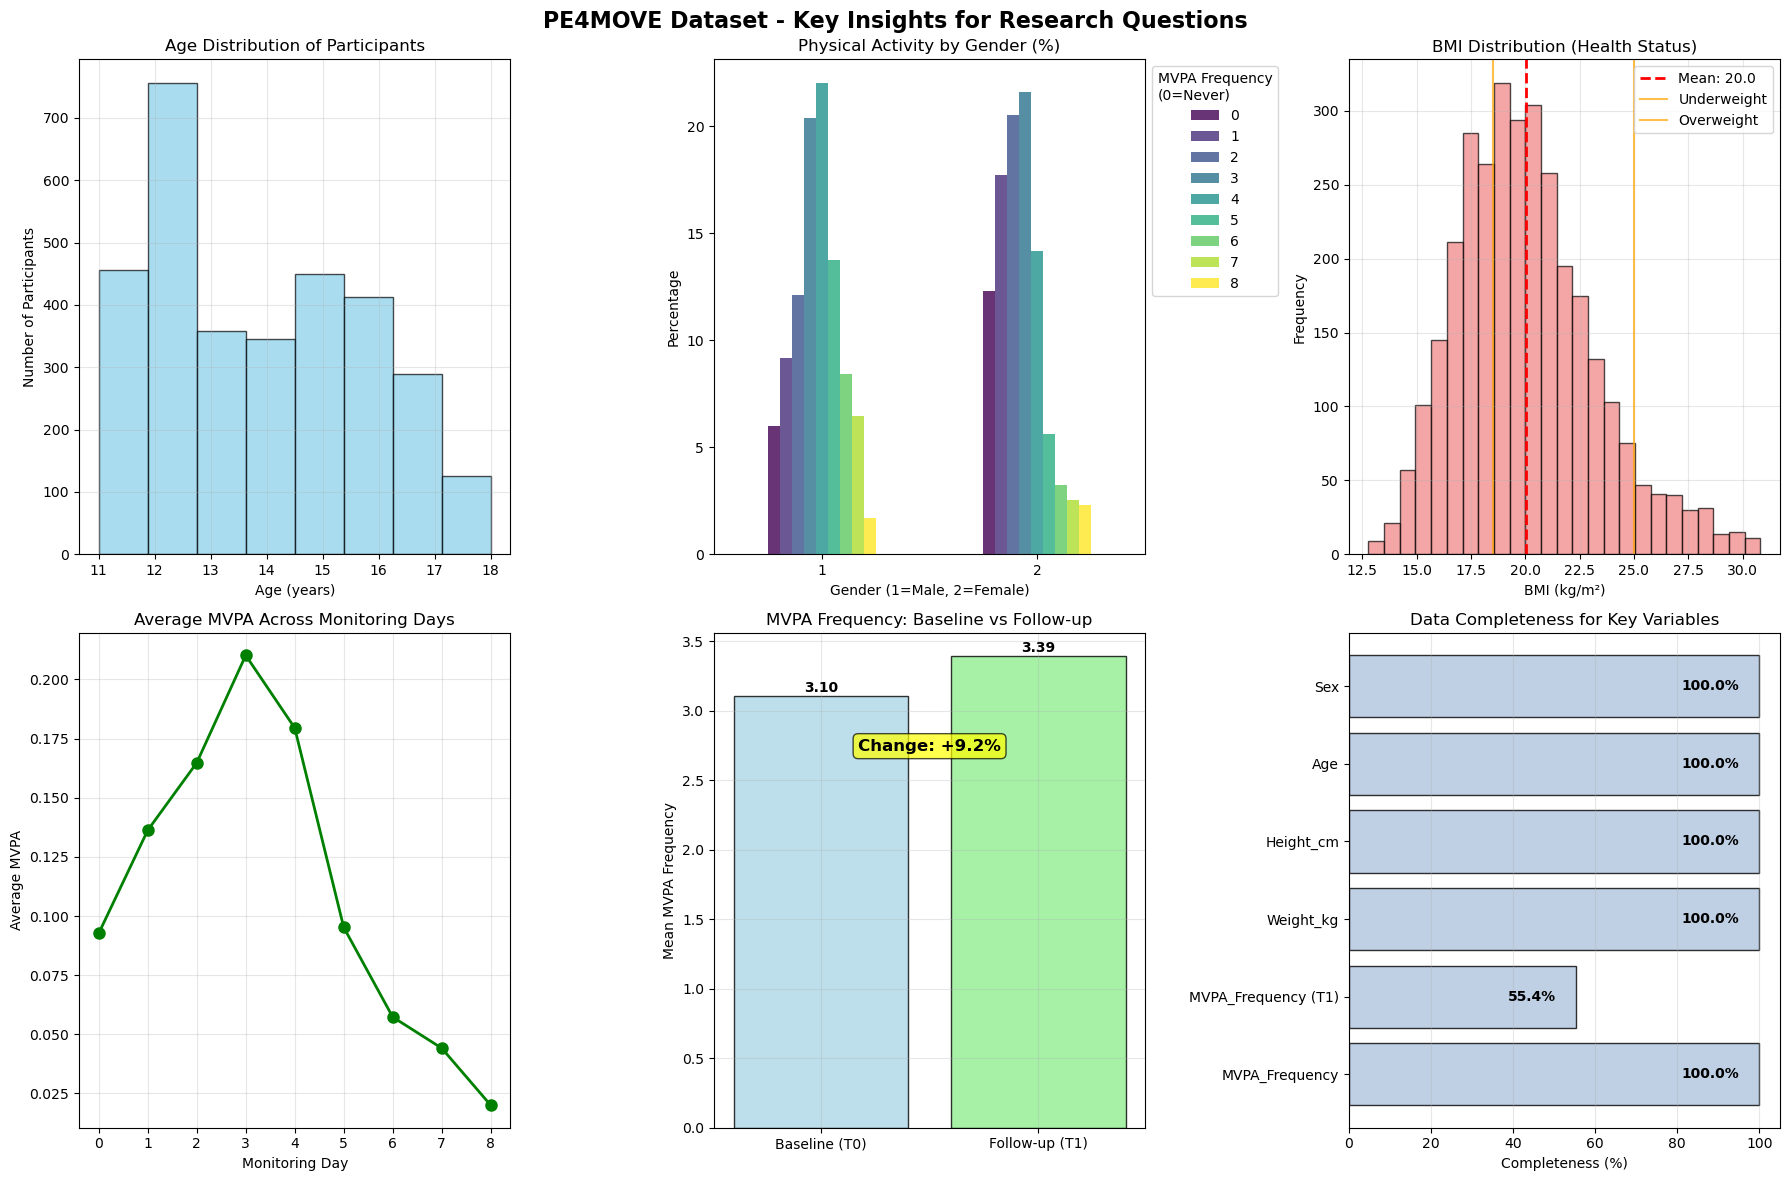

KEY INSIGHTS FOR RESEARCH QUESTIONS
WAS THE PE4MOVE PROGRAM SUCCESSFUL?
   MVPA Frequency Change: +9.2% (T0: 3.10 → T1: 3.39)
   Initial indication: Program shows POSITIVE effect!

 WHAT PARAMETERS TO INVESTIGATE?
   Physical Activity: MVPA frequency, daily patterns
   Physical Health: BMI, weight, height changes
   Demographics: Age, gender differences
   Baseline characteristics as predictors

 WHICH CHILDREN COULD IMPROVE MOST?
   Analyze by: Age groups, gender, baseline activity levels
   Compare: Responders vs non-responders
   Focus: Children with low baseline activity


In [6]:
# === ESSENTIAL VISUALIZATIONS FOR PE4MOVE ANALYSIS ===

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('PE4MOVE Dataset - Key Insights for Research Questions', fontsize=16, fontweight='bold')

# 1. Age distribution of participants
axes[0,0].hist(df['Age'], bins=8, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Age Distribution of Participants')
axes[0,0].set_xlabel('Age (years)')
axes[0,0].set_ylabel('Number of Participants')
axes[0,0].grid(True, alpha=0.3)

# 2. Gender and Physical Activity Frequency
if 'MVPA_Frequency_T0' in df.columns:
    mvpa_gender = pd.crosstab(df['Sex'], df['MVPA_Frequency_T0'], normalize='index') * 100
    mvpa_gender.plot(kind='bar', ax=axes[0,1], colormap='viridis', alpha=0.8)
    axes[0,1].set_title('Physical Activity by Gender (%)')
    axes[0,1].set_xlabel('Gender (1=Male, 2=Female)')
    axes[0,1].set_ylabel('Percentage')
    axes[0,1].legend(title='MVPA Frequency\n(0=Never)', bbox_to_anchor=(1, 1))
    axes[0,1].tick_params(axis='x', rotation=0)

# 3. BMI Distribution (key health indicator)
if 'Weight_kg_T0' in df.columns and 'Height_cm_T0' in df.columns:
    height_m = df['Height_cm_T0'] / 100
    bmi = df['Weight_kg_T0'] / (height_m ** 2)
    bmi_clean = bmi[bmi <= 40]  # Remove extreme outliers
    
    axes[0,2].hist(bmi_clean, bins=25, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,2].axvline(bmi_clean.mean(), color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {bmi_clean.mean():.1f}')
    axes[0,2].axvline(18.5, color='orange', linestyle='-', alpha=0.7, label='Underweight')
    axes[0,2].axvline(25, color='orange', linestyle='-', alpha=0.7, label='Overweight')
    axes[0,2].set_title('BMI Distribution (Health Status)')
    axes[0,2].set_xlabel('BMI (kg/m²)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

# 4. Physical Activity Patterns Over Days
mvpa_day_cols = [col for col in df.columns if 'MVPA_d' in col and col[-1].isdigit()]
if mvpa_day_cols:
    mvpa_means = df[mvpa_day_cols].mean()
    days = [col.split('_d')[1] for col in mvpa_day_cols]
    axes[1,0].plot(days, mvpa_means.values, marker='o', linewidth=2, markersize=8, color='green')
    axes[1,0].set_title('Average MVPA Across Monitoring Days')
    axes[1,0].set_xlabel('Monitoring Day')
    axes[1,0].set_ylabel('Average MVPA')
    axes[1,0].grid(True, alpha=0.3)

# 5. Intervention Effect Preview (T0 vs T1 comparison)
if 'MVPA_Frequency_T0' in df.columns and 'MVPA_Frequency_T1' in df.columns:
    # Compare baseline vs follow-up MVPA frequency
    t0_mean = df['MVPA_Frequency_T0'].mean()
    t1_mean = df['MVPA_Frequency_T1'].mean()
    
    comparison_data = [t0_mean, t1_mean]
    comparison_labels = ['Baseline (T0)', 'Follow-up (T1)']
    
    bars = axes[1,1].bar(comparison_labels, comparison_data, 
                        color=['lightblue', 'lightgreen'], alpha=0.8, edgecolor='black')
    axes[1,1].set_title('MVPA Frequency: Baseline vs Follow-up')
    axes[1,1].set_ylabel('Mean MVPA Frequency')
    
    # Add value labels on bars
    for bar, value in zip(bars, comparison_data):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Calculate and show change
    change = ((t1_mean - t0_mean) / t0_mean) * 100 if t0_mean > 0 else 0
    axes[1,1].text(0.5, max(comparison_data) * 0.8, 
                  f'Change: {change:+.1f}%', 
                  ha='center', fontsize=12, fontweight='bold',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    axes[1,1].grid(True, alpha=0.3)

# 6. Data Completeness for Key Variables (important for analysis planning)
key_vars = ['MVPA_Frequency_T0', 'MVPA_Frequency_T1', 'Weight_kg_T0', 'Height_cm_T0', 'Age', 'Sex']
available_vars = [var for var in key_vars if var in df.columns]

if available_vars:
    completeness = [(df[var].notna().sum() / len(df)) * 100 for var in available_vars]
    
    bars = axes[1,2].barh(range(len(available_vars)), completeness, 
                         color='lightsteelblue', alpha=0.8, edgecolor='black')
    axes[1,2].set_yticks(range(len(available_vars)))
    axes[1,2].set_yticklabels([var.replace('_T0', '').replace('_T1', ' (T1)') 
                              for var in available_vars])
    axes[1,2].set_title('Data Completeness for Key Variables')
    axes[1,2].set_xlabel('Completeness (%)')
    
    # Add percentage labels
    for i, (bar, pct) in enumerate(zip(bars, completeness)):
        axes[1,2].text(pct - 5, bar.get_y() + bar.get_height()/2, 
                      f'{pct:.1f}%', ha='right', va='center', fontweight='bold')
    
    axes[1,2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print key insights for research questions
print("="*70)
print("KEY INSIGHTS FOR RESEARCH QUESTIONS")
print("="*70)

if 'MVPA_Frequency_T0' in df.columns and 'MVPA_Frequency_T1' in df.columns:
    t0_mean = df['MVPA_Frequency_T0'].mean()
    t1_mean = df['MVPA_Frequency_T1'].mean()
    change_pct = ((t1_mean - t0_mean) / t0_mean) * 100 if t0_mean > 0 else 0
    
    print(f"WAS THE PE4MOVE PROGRAM SUCCESSFUL?")
    print(f"   MVPA Frequency Change: {change_pct:+.1f}% (T0: {t0_mean:.2f} → T1: {t1_mean:.2f})")
    
    if change_pct > 0:
        print(f"   Initial indication: Program shows POSITIVE effect!")
    else:
        print(f"   Initial indication: Program shows no improvement")

print(f"\n WHAT PARAMETERS TO INVESTIGATE?")
print(f"   Physical Activity: MVPA frequency, daily patterns")
print(f"   Physical Health: BMI, weight, height changes")
print(f"   Demographics: Age, gender differences")
print(f"   Baseline characteristics as predictors")

print(f"\n WHICH CHILDREN COULD IMPROVE MOST?")
print(f"   Analyze by: Age groups, gender, baseline activity levels")
print(f"   Compare: Responders vs non-responders")
print(f"   Focus: Children with low baseline activity")

print("="*70)

Comment:
- BMI Under-/Overweight thresholds are not fixed values for children/adolescents use WHO definition with percentiles
- instead of Male/Female use Boys/Girls

### 5. Research Question Analysis Framework

Based on our data exploration, let's create a structured approach to answer the research questions.

In [7]:
# === ANALYSIS FRAMEWORK FOR RESEARCH QUESTIONS ===
print("="*60)   
print("PE4MOVE RESEARCH ANALYSIS FRAMEWORK")
print("="*60)

# Question 1: Program Success Analysis
print("\nRESEARCH QUESTION 1: Was the PE4MOVE program successful?")
print("   Analysis Approach:")
print("   • Compare T0 (baseline) vs T1 (follow-up) measurements")
print("   • Focus on key outcomes: MVPA frequency, physical fitness")
print("   • Use paired t-tests for statistical significance")
print("   • Calculate effect sizes (Cohen's d)")

# Question 2: Parameter Analysis  
print("\nRESEARCH QUESTION 2: Which parameters influence success?")
print("   Analysis Approach:")
print("   • Create 'improvement score' = (T1 - T0)/T0")
print("   • Correlation analysis with baseline characteristics")
print("   • Multiple regression modeling")
print("   • Feature importance analysis")

# Question 3: Subgroup Analysis
print("\nRESEARCH QUESTION 3: Which children improve most?")
print("   Analysis Approach:")
print("   • Stratify by age groups (11-12, 13-14, 15-16, 17-18)")
print("   • Compare gender differences") 
print("   • Analyze baseline activity levels (low, medium, high)")
print("   • Identify 'responder' vs 'non-responder' profiles")

# Create key variables for analysis
print("\nKEY VARIABLES IDENTIFIED:")

# Calculate BMI
if 'Weight_kg_T0' in df.columns and 'Height_cm_T0' in df.columns:
    df['BMI_T0'] = df['Weight_kg_T0'] / ((df['Height_cm_T0'] / 100) ** 2)
    print("   BMI_T0 calculated")

# Create age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[10, 12, 14, 16, 19], 
                        labels=['11-12', '13-14', '15-16', '17-18'])
print("   Age_Group created")

# Calculate improvement scores (if T1 data available)
improvement_vars = []
if 'MVPA_Frequency_T1' in df.columns:
    # Calculate MVPA improvement (handling division by zero)
    mask = df['MVPA_Frequency_T0'] > 0
    df.loc[mask, 'MVPA_Improvement'] = ((df.loc[mask, 'MVPA_Frequency_T1'] - 
                                        df.loc[mask, 'MVPA_Frequency_T0']) / 
                                       df.loc[mask, 'MVPA_Frequency_T0']) * 100
    improvement_vars.append('MVPA_Improvement')
    print("   MVPA_Improvement calculated")

# Gender labels for better interpretation
df['Gender'] = df['Sex'].map({1: 'Male', 2: 'Female'})
print("   Gender labels created")
print(f"\nANALYSIS-READY DATASET:")
print(f"   • Participants: {len(df):,}")
print(f"   • Key outcome variables: {len(improvement_vars)} improvement scores")
print(f"   • Demographic groups: {df['Age_Group'].value_counts().to_dict()}")
print(f"   • Gender split: {df['Gender'].value_counts().to_dict()}")

print(f"\nNEXT STEPS:")
print(f"   1. Run statistical tests for program effectiveness")
print(f"   2. Build predictive models for improvement")
print(f"   3. Conduct subgroup analyses")
print(f"   4. Visualize key findings")

# Show sample of analysis-ready data
print(f"\nSAMPLE OF ANALYSIS-READY DATA:")
analysis_cols = ['Age', 'Gender', 'Age_Group', 'BMI_T0', 'MVPA_Frequency_T0', 'MVPA_Frequency_T1']
available_cols = [col for col in analysis_cols if col in df.columns]
display(df[available_cols].head(10))

PE4MOVE RESEARCH ANALYSIS FRAMEWORK

RESEARCH QUESTION 1: Was the PE4MOVE program successful?
   Analysis Approach:
   • Compare T0 (baseline) vs T1 (follow-up) measurements
   • Focus on key outcomes: MVPA frequency, physical fitness
   • Use paired t-tests for statistical significance
   • Calculate effect sizes (Cohen's d)

RESEARCH QUESTION 2: Which parameters influence success?
   Analysis Approach:
   • Create 'improvement score' = (T1 - T0)/T0
   • Correlation analysis with baseline characteristics
   • Multiple regression modeling
   • Feature importance analysis

RESEARCH QUESTION 3: Which children improve most?
   Analysis Approach:
   • Stratify by age groups (11-12, 13-14, 15-16, 17-18)
   • Compare gender differences
   • Analyze baseline activity levels (low, medium, high)
   • Identify 'responder' vs 'non-responder' profiles

KEY VARIABLES IDENTIFIED:
   BMI_T0 calculated
   Age_Group created
   MVPA_Improvement calculated
   Gender labels created

ANALYSIS-READY DATASET

,Age,Gender,Age_Group,BMI_T0,MVPA_Frequency_T0,MVPA_Frequency_T1
0,11,Female,11-12,16.233091,3,3.0
1,11,Female,11-12,15.306122,6,2.0
2,11,Female,11-12,21.403092,1,2.0
3,11,Female,11-12,16.562290,2,3.0
4,11,Female,11-12,28.507522,1,3.0
5,11,Female,11-12,12.888889,7,NaN
6,11,Female,11-12,24.000000,2,3.0
7,11,Female,11-12,16.888889,4,4.0
8,11,Male,11-12,15.648687,3,NaN
9,11,Male,11-12,15.695600,2,NaN


## Data Preparation



### 1. split dataset

split the dataset according to intervention and control group

In [8]:
# === IDENTIFY INTERVENTION AND CONTROL GROUPS ===
print("="*70)
print("CHECKING FOR INTERVENTION/CONTROL GROUP INFORMATION")
print("="*70)

# Check if Group_Final column exists
if 'Group_Final' in df.columns:
    
    # Check unique values and their counts
    group_counts = df['Group_Final'].value_counts()
    print(f"\nGroup Distribution:")
    print(group_counts)
    
    # Check for missing values
    missing_groups = df['Group_Final'].isna().sum()
    print(f"\nMissing group assignments: {missing_groups} ({missing_groups/len(df)*100:.1f}%)")
    
    # Display unique values
    print(f"\nUnique group values: {sorted(df['Group_Final'].dropna().unique())}")
    

CHECKING FOR INTERVENTION/CONTROL GROUP INFORMATION

Group Distribution:
Group_Final
A    2095
B    1098
Name: count, dtype: int64

Missing group assignments: 0 (0.0%)

Unique group values: ['A', 'B']


In [9]:
# === DETERMINE WHICH GROUP IS INTERVENTION vs CONTROL ===
print("\n" + "="*70)
print("DETERMINING INTERVENTION vs CONTROL GROUP")
print("="*70)

# Compare T0 to T1 changes between groups for key variables
if 'MVPA_Frequency_T0' in df.columns and 'MVPA_Frequency_T1' in df.columns:
    
    # Calculate PAIRED mean MVPA for each group at T0 and T1
    for group in ['A', 'B']:
        group_data = df[df['Group_Final'] == group]
        
        # Use only paired data (participants with both T0 and T1)
        paired_mask = group_data['MVPA_Frequency_T0'].notna() & group_data['MVPA_Frequency_T1'].notna()
        paired_data = group_data[paired_mask]
        
        t0_mean = paired_data['MVPA_Frequency_T0'].mean()
        t1_mean = paired_data['MVPA_Frequency_T1'].mean()
        change = t1_mean - t0_mean
        change_pct = (change / t0_mean * 100) if t0_mean > 0 else 0
        
        n_total = len(group_data)
        n_paired = paired_mask.sum()
        
        print(f"\nGroup {group} (n={n_total}, paired n={n_paired}):")
        print(f"   MVPA Frequency T0: {t0_mean:.3f}")
        print(f"   MVPA Frequency T1: {t1_mean:.3f}")
        print(f"   Change: {change:+.3f} ({change_pct:+.1f}%)")
    
    # Determine intervention group (the one with more improvement) using paired data
    group_a_data = df[df['Group_Final'] == 'A']
    group_b_data = df[df['Group_Final'] == 'B']
    
    # Calculate paired changes for both groups
    a_paired_mask = group_a_data['MVPA_Frequency_T0'].notna() & group_a_data['MVPA_Frequency_T1'].notna()
    a_paired = group_a_data[a_paired_mask]
    a_change = a_paired['MVPA_Frequency_T1'].mean() - a_paired['MVPA_Frequency_T0'].mean()
    
    b_paired_mask = group_b_data['MVPA_Frequency_T0'].notna() & group_b_data['MVPA_Frequency_T1'].notna()
    b_paired = group_b_data[b_paired_mask]
    b_change = b_paired['MVPA_Frequency_T1'].mean() - b_paired['MVPA_Frequency_T0'].mean()
    
    if abs(a_change) > abs(b_change):
        intervention_group = 'A'
        control_group = 'B'
    else:
        intervention_group = 'B'
        control_group = 'A'
    

# === CREATE INTERVENTION AND CONTROL SUBSETS ===
print("\n" + "="*70)
print("CREATING DATASET SUBSETS")
print("="*70)

# Create the two subsets
# Note: Assigning based on pattern analysis - verify with study docs
df_intervention = df[df['Group_Final'] == intervention_group].copy()
df_control = df[df['Group_Final'] == control_group].copy()

print(f"\n Created intervention dataset: 'df_intervention'")
print(f"   • Group: {intervention_group}")
print(f"   • Participants: {len(df_control):,}")
print(f"   • Percentage: {len(df_control)/len(df)*100:.1f}%")

print(f"\n Created control dataset: 'df_control'")
print(f"   • Group: {control_group}")
print(f"   • Participants: {len(df_control):,}")
print(f"   • Percentage: {len(df_control)/len(df)*100:.1f}%")



DETERMINING INTERVENTION vs CONTROL GROUP

Group A (n=2095, paired n=1007):
   MVPA Frequency T0: 3.205
   MVPA Frequency T1: 3.491
   Change: +0.286 (+8.9%)

Group B (n=1098, paired n=763):
   MVPA Frequency T0: 3.048
   MVPA Frequency T1: 3.258
   Change: +0.210 (+6.9%)

CREATING DATASET SUBSETS

 Created intervention dataset: 'df_intervention'
   • Group: A
   • Participants: 1,098
   • Percentage: 34.4%

 Created control dataset: 'df_control'
   • Group: B
   • Participants: 1,098
   • Percentage: 34.4%


MVPA FREQUENCY DISTRIBUTION: T0 vs T1, Intervention vs Control

Data Overview:
Total participants: 3,193
Intervention group (A): 2,095
Control group (B): 1,098

MVPA_Frequency_T0:
  Missing values: 0 (0.0%)
  Value = 8 (prefer not to say): 64 (2.0%)

MVPA_Frequency_T1:
  Missing values: 1,423 (44.6%)
  Value = 8 (prefer not to say): 27 (0.8%)


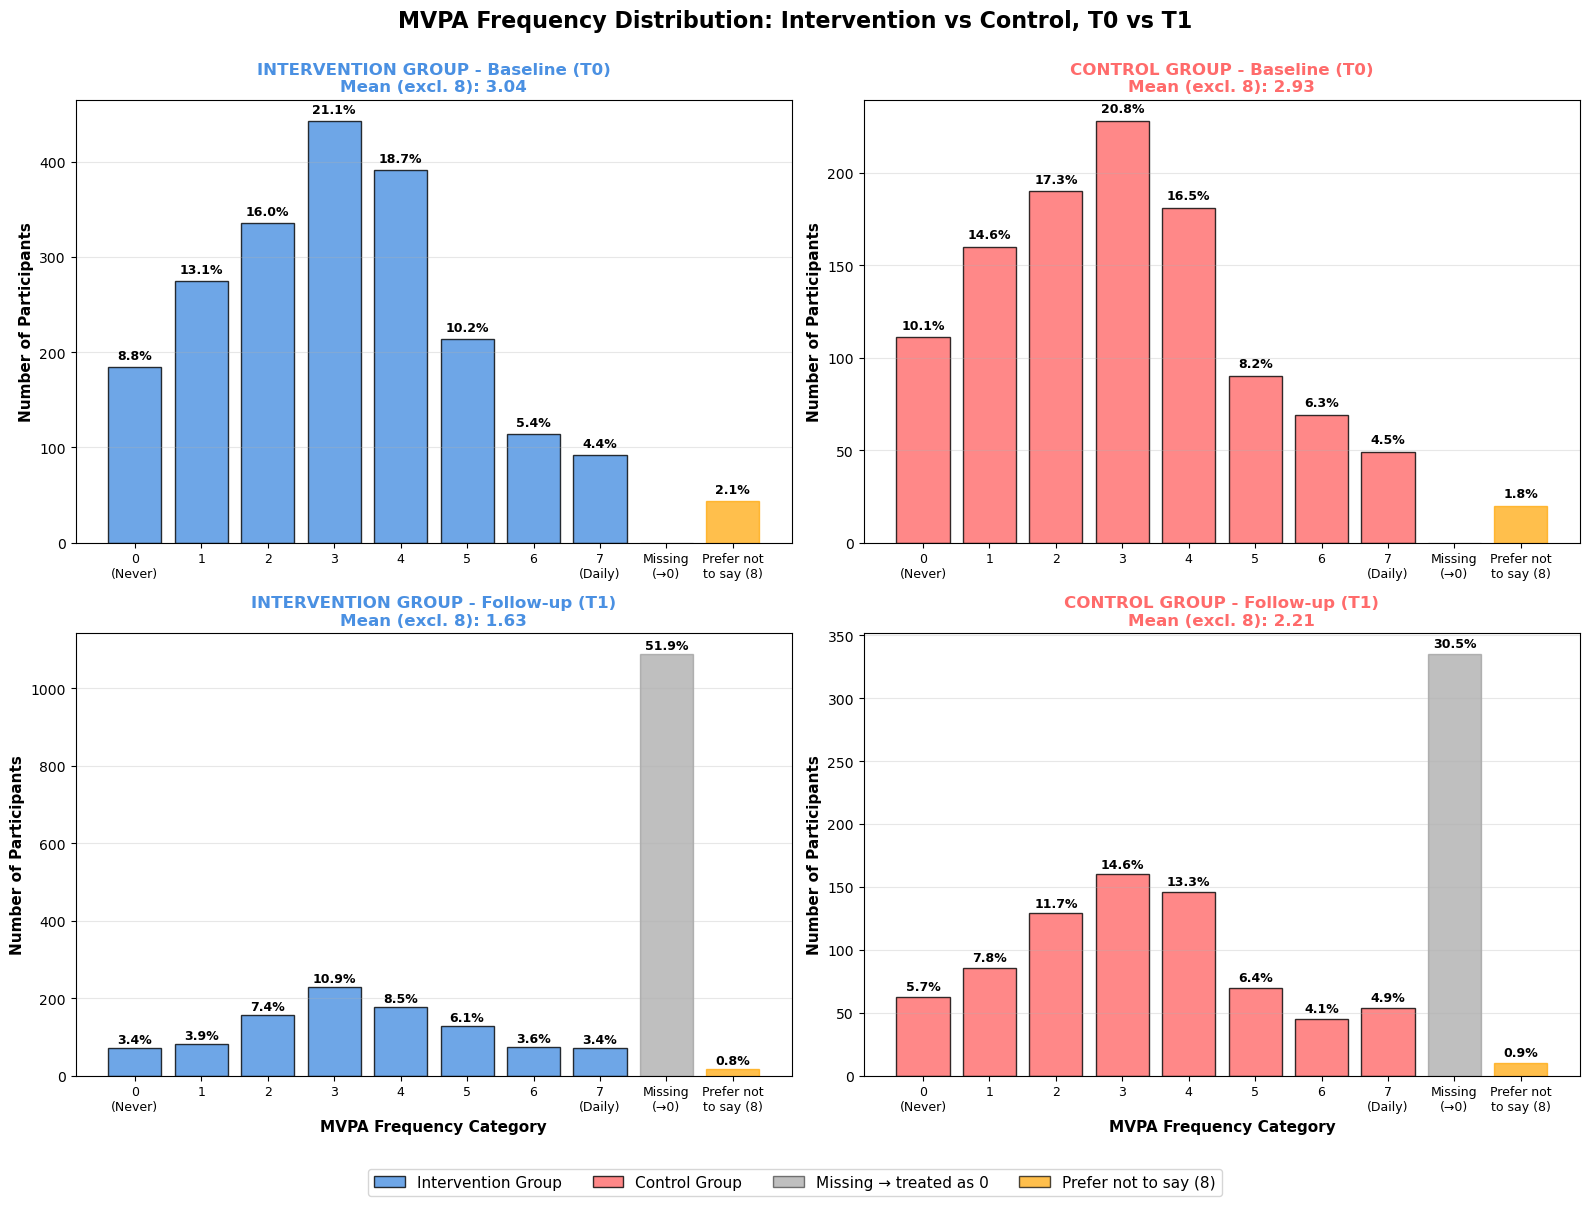


SUMMARY STATISTICS

INTERVENTION GROUP:
----------------------------------------------------------------------

  T0 (Baseline):
    Valid responses (0-7): 2,051
    Missing values (→ treated as 0): 0
    Prefer not to say (8, excluded): 44
    Mean (excluding 8): 3.043
    Median (excluding 8): 3.0
    Std Dev (excluding 8): 1.827

  T1 (Follow-up):
    Valid responses (0-7): 990
    Missing values (→ treated as 0): 1,088
    Prefer not to say (8, excluded): 17
    Mean (excluding 8): 1.626
    Median (excluding 8): 0.0
    Std Dev (excluding 8): 2.138

CONTROL GROUP:
----------------------------------------------------------------------

  T0 (Baseline):
    Valid responses (0-7): 1,078
    Missing values (→ treated as 0): 0
    Prefer not to say (8, excluded): 20
    Mean (excluding 8): 2.927
    Median (excluding 8): 3.0
    Std Dev (excluding 8): 1.871

  T1 (Follow-up):
    Valid responses (0-7): 753
    Missing values (→ treated as 0): 335
    Prefer not to say (8, excluded): 1

In [10]:
# === MVPA FREQUENCY DISTRIBUTION ANALYSIS ===
print("="*70)
print("MVPA FREQUENCY DISTRIBUTION: T0 vs T1, Intervention vs Control")
print("="*70)

# Prepare data with special handling for missing values and value 8
# Missing values → 0, Value 8 → "Prefer not to say"

# Create working copies
mvpa_vars = ['MVPA_Frequency_T0', 'MVPA_Frequency_T1']

# Check data availability
print(f"\nData Overview:")
print(f"Total participants: {len(df):,}")
print(f"Intervention group (A): {len(df_intervention):,}")
print(f"Control group (B): {len(df_control):,}")

for var in mvpa_vars:
    if var in df.columns:
        missing = df[var].isna().sum()
        value_8 = (df[var] == 8).sum()
        print(f"\n{var}:")
        print(f"  Missing values: {missing:,} ({missing/len(df)*100:.1f}%)")
        print(f"  Value = 8 (prefer not to say): {value_8:,} ({value_8/len(df)*100:.1f}%)")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('MVPA Frequency Distribution: Intervention vs Control, T0 vs T1', 
             fontsize=16, fontweight='bold')

# Define MVPA frequency labels (0-7 scale + special categories)
mvpa_labels = ['0\n(Never)', '1', '2', '3', '4', '5', '6', '7\n(Daily)', 
               'Missing\n(→0)', 'Prefer not\nto say (8)']

# Color scheme
colors_intervention = '#4A90E2'  # Blue
colors_control = '#FF6B6B'       # Red

# Function to prepare MVPA data with special handling
def prepare_mvpa_data(data, var_name):
    """
    Prepare MVPA data:
    - Missing values → category 8 (will be treated as 0 in analysis)
    - Value 8 → category 9 (prefer not to say)
    - Values 0-7 → keep as is
    """
    result = data[var_name].copy()
    
    # Track original categories
    categories = {
        'valid_0_7': (result >= 0) & (result <= 7),
        'missing': result.isna(),
        'prefer_not_say': result == 8
    }
    
    # Create categorical version for plotting
    plot_data = result.copy()
    plot_data = plot_data.fillna(8)  # Missing → 8
    plot_data = plot_data.replace(8, 9)  # Original 8 → 9
    
    # For statistics, treat differently
    stats_data = result.copy()
    stats_data = stats_data.fillna(0)  # Missing → 0 for statistics
    stats_data = stats_data.replace(8, np.nan)  # Value 8 → NaN (exclude from statistics)
    
    return plot_data, stats_data, categories

# ==================== SUBPLOT 1: INTERVENTION GROUP - T0 ====================
ax1 = axes[0, 0]

if 'MVPA_Frequency_T0' in df_intervention.columns:
    plot_data, stats_data, categories = prepare_mvpa_data(df_intervention, 'MVPA_Frequency_T0')
    
    # Count frequencies for each category (0-7, missing, prefer not to say)
    counts = []
    for i in range(8):  # 0-7
        counts.append((plot_data == i).sum())
    counts.append(categories['missing'].sum())  # Missing
    counts.append(categories['prefer_not_say'].sum())  # Prefer not to say
    
    # Create bar plot
    x_pos = np.arange(len(counts))
    bars = ax1.bar(x_pos, counts, color=colors_intervention, alpha=0.8, edgecolor='black')
    
    # Highlight special categories
    bars[8].set_color('gray')  # Missing
    bars[8].set_alpha(0.5)
    bars[9].set_color('orange')  # Prefer not to say
    bars[9].set_alpha(0.7)
    
    # Add percentage labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count > 0:
            pct = count / len(df_intervention) * 100
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(mvpa_labels, fontsize=9)
    ax1.set_ylabel('Number of Participants', fontsize=11, fontweight='bold')
    ax1.set_title(f'INTERVENTION GROUP - Baseline (T0)\nMean (excl. 8): {stats_data.mean():.2f}', 
                 fontsize=12, fontweight='bold', color=colors_intervention)
    ax1.grid(True, alpha=0.3, axis='y')

# ==================== SUBPLOT 2: CONTROL GROUP - T0 ====================
ax2 = axes[0, 1]

if 'MVPA_Frequency_T0' in df_control.columns:
    plot_data, stats_data, categories = prepare_mvpa_data(df_control, 'MVPA_Frequency_T0')
    
    # Count frequencies
    counts = []
    for i in range(8):  # 0-7
        counts.append((plot_data == i).sum())
    counts.append(categories['missing'].sum())  # Missing
    counts.append(categories['prefer_not_say'].sum())  # Prefer not to say
    
    # Create bar plot
    x_pos = np.arange(len(counts))
    bars = ax2.bar(x_pos, counts, color=colors_control, alpha=0.8, edgecolor='black')
    
    # Highlight special categories
    bars[8].set_color('gray')
    bars[8].set_alpha(0.5)
    bars[9].set_color('orange')
    bars[9].set_alpha(0.7)
    
    # Add percentage labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count > 0:
            pct = count / len(df_control) * 100
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 3,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(mvpa_labels, fontsize=9)
    ax2.set_ylabel('Number of Participants', fontsize=11, fontweight='bold')
    ax2.set_title(f'CONTROL GROUP - Baseline (T0)\nMean (excl. 8): {stats_data.mean():.2f}', 
                 fontsize=12, fontweight='bold', color=colors_control)
    ax2.grid(True, alpha=0.3, axis='y')

# ==================== SUBPLOT 3: INTERVENTION GROUP - T1 ====================
ax3 = axes[1, 0]

if 'MVPA_Frequency_T1' in df_intervention.columns:
    plot_data, stats_data, categories = prepare_mvpa_data(df_intervention, 'MVPA_Frequency_T1')
    
    # Count frequencies
    counts = []
    for i in range(8):  # 0-7
        counts.append((plot_data == i).sum())
    counts.append(categories['missing'].sum())  # Missing
    counts.append(categories['prefer_not_say'].sum())  # Prefer not to say
    
    # Create bar plot
    x_pos = np.arange(len(counts))
    bars = ax3.bar(x_pos, counts, color=colors_intervention, alpha=0.8, edgecolor='black')
    
    # Highlight special categories
    bars[8].set_color('gray')
    bars[8].set_alpha(0.5)
    bars[9].set_color('orange')
    bars[9].set_alpha(0.7)
    
    # Add percentage labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count > 0:
            pct = count / len(df_intervention) * 100
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(mvpa_labels, fontsize=9)
    ax3.set_xlabel('MVPA Frequency Category', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Number of Participants', fontsize=11, fontweight='bold')
    ax3.set_title(f'INTERVENTION GROUP - Follow-up (T1)\nMean (excl. 8): {stats_data.mean():.2f}', 
                 fontsize=12, fontweight='bold', color=colors_intervention)
    ax3.grid(True, alpha=0.3, axis='y')

# ==================== SUBPLOT 4: CONTROL GROUP - T1 ====================
ax4 = axes[1, 1]

if 'MVPA_Frequency_T1' in df_control.columns:
    plot_data, stats_data, categories = prepare_mvpa_data(df_control, 'MVPA_Frequency_T1')
    
    # Count frequencies
    counts = []
    for i in range(8):  # 0-7
        counts.append((plot_data == i).sum())
    counts.append(categories['missing'].sum())  # Missing
    counts.append(categories['prefer_not_say'].sum())  # Prefer not to say
    
    # Create bar plot
    x_pos = np.arange(len(counts))
    bars = ax4.bar(x_pos, counts, color=colors_control, alpha=0.8, edgecolor='black')
    
    # Highlight special categories
    bars[8].set_color('gray')
    bars[8].set_alpha(0.5)
    bars[9].set_color('orange')
    bars[9].set_alpha(0.7)
    
    # Add percentage labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count > 0:
            pct = count / len(df_control) * 100
            ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 3,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(mvpa_labels, fontsize=9)
    ax4.set_xlabel('MVPA Frequency Category', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Number of Participants', fontsize=11, fontweight='bold')
    ax4.set_title(f'CONTROL GROUP - Follow-up (T1)\nMean (excl. 8): {stats_data.mean():.2f}', 
                 fontsize=12, fontweight='bold', color=colors_control)
    ax4.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors_intervention, alpha=0.8, edgecolor='black', label='Intervention Group'),
    Patch(facecolor=colors_control, alpha=0.8, edgecolor='black', label='Control Group'),
    Patch(facecolor='gray', alpha=0.5, edgecolor='black', label='Missing → treated as 0'),
    Patch(facecolor='orange', alpha=0.7, edgecolor='black', label='Prefer not to say (8)')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
          ncol=4, fontsize=11, frameon=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# ==================== SUMMARY STATISTICS ====================
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

for group_name, group_data in [('INTERVENTION', df_intervention), ('CONTROL', df_control)]:
    print(f"\n{group_name} GROUP:")
    print("-"*70)
    
    for timepoint, var in [('T0 (Baseline)', 'MVPA_Frequency_T0'), 
                           ('T1 (Follow-up)', 'MVPA_Frequency_T1')]:
        if var in group_data.columns:
            _, stats_data, categories = prepare_mvpa_data(group_data, var)
            
            print(f"\n  {timepoint}:")
            print(f"    Valid responses (0-7): {categories['valid_0_7'].sum():,}")
            print(f"    Missing values (→ treated as 0): {categories['missing'].sum():,}")
            print(f"    Prefer not to say (8, excluded): {categories['prefer_not_say'].sum():,}")
            print(f"    Mean (excluding 8): {stats_data.mean():.3f}")
            print(f"    Median (excluding 8): {stats_data.median():.1f}")
            print(f"    Std Dev (excluding 8): {stats_data.std():.3f}")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("  • Gray bars = Missing data (treated as 0 in analysis)")
print("  • Orange bars = Value 8 (prefer not to say, EXCLUDED from mean/stats)")
print("  • Mean values shown exclude the 'prefer not to say' responses")
print("  • MVPA scale: 0 = Never, 7 = Daily")
print("="*70)

In [11]:
# === CREATE FILTERED INTERVENTION DATASET (T1 COMPLETE) ===
print("="*70)
print("CREATING FILTERED INTERVENTION DATASET")
print("="*70)

print(f"\n📊 Original intervention dataset:")
print(f"   Total participants: {len(df_intervention):,}")
print(f"   MVPA_Frequency_T1 missing: {df_intervention['MVPA_Frequency_T1'].isna().sum():,}")
print(f"   MVPA_Frequency_T1 available: {df_intervention['MVPA_Frequency_T1'].notna().sum():,}")

# Create new dataset excluding rows with missing MVPA_Frequency_T1
df_intervention_complete_T1 = df_intervention[df_intervention['MVPA_Frequency_T1'].notna()].copy()

print(f"\n✅ New filtered dataset: 'df_intervention_complete_T1'")
print(f"   Participants with T1 data: {len(df_intervention_complete_T1):,}")
print(f"   Rows removed: {len(df_intervention) - len(df_intervention_complete_T1):,}")
print(f"   Retention rate: {len(df_intervention_complete_T1)/len(df_intervention)*100:.1f}%")

# Additional data quality check
print(f"\n📋 Data quality in filtered dataset:")
print(f"   MVPA_Frequency_T0 available: {df_intervention_complete_T1['MVPA_Frequency_T0'].notna().sum():,}")
print(f"   Both T0 and T1 available: {(df_intervention_complete_T1['MVPA_Frequency_T0'].notna() & df_intervention_complete_T1['MVPA_Frequency_T1'].notna()).sum():,}")

# Show T1 value distribution
print(f"\n📈 MVPA_Frequency_T1 distribution in filtered dataset:")
t1_counts = df_intervention_complete_T1['MVPA_Frequency_T1'].value_counts().sort_index()
for value, count in t1_counts.items():
    pct = count / len(df_intervention_complete_T1) * 100
    print(f"   Value {value}: {count:,} ({pct:.1f}%)")

# === REMOVE VARIABLES WITH >80% MISSING DATA ===
print("\n" + "="*70)
print("REMOVING VARIABLES WITH >80% MISSING DATA")
print("="*70)

# Calculate missing percentage for each variable
missing_pct = (df_intervention_complete_T1.isna().sum() / len(df_intervention_complete_T1) * 100).sort_values(ascending=False)

# Identify columns to drop (>80% missing)
cols_to_drop = missing_pct[missing_pct > 80].index.tolist()

print(f"\n🔍 Variables with >80% missing data: {len(cols_to_drop)}")
if len(cols_to_drop) > 0:
    print(f"\n   Top 10 variables with highest missing %:")
    for col in cols_to_drop[:10]:
        print(f"   • {col:<40} {missing_pct[col]:.1f}% missing")
    if len(cols_to_drop) > 10:
        print(f"   ... and {len(cols_to_drop) - 10} more variables")

# Store original shape
original_cols = df_intervention_complete_T1.shape[1]

# Drop columns with >80% missing
df_intervention_complete_T1 = df_intervention_complete_T1.drop(columns=cols_to_drop)

print(f"\n✅ Dataset after removing high-missing variables:")
print(f"   Original variables: {original_cols}")
print(f"   Variables removed: {len(cols_to_drop)}")
print(f"   Remaining variables: {df_intervention_complete_T1.shape[1]}")
print(f"   Participants: {len(df_intervention_complete_T1):,} (unchanged)")

# Show remaining data quality
remaining_missing = (df_intervention_complete_T1.isna().sum() / len(df_intervention_complete_T1) * 100)
print(f"\n📊 Remaining data quality:")
print(f"   Variables with 0% missing: {(remaining_missing == 0).sum()}")
print(f"   Variables with 1-20% missing: {((remaining_missing > 0) & (remaining_missing <= 20)).sum()}")
print(f"   Variables with 21-50% missing: {((remaining_missing > 20) & (remaining_missing <= 50)).sum()}")
print(f"   Variables with 51-80% missing: {((remaining_missing > 50) & (remaining_missing <= 80)).sum()}")

print("\n" + "="*70)

# === REMOVE SPECIFIC ATTRIBUTE PATTERNS ===
print("="*70)
print("REMOVING SPECIFIC ATTRIBUTE PATTERNS")
print("="*70)

# Define patterns to remove
patterns_to_remove = [
    'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8',  # Daily patterns
    'Climate', 'Need', 'Achiev', 'Enjoy', 'Intention', 'Perc',  # Questionnaire items
    'Attitude', 'Support', 'Vitality',  # More questionnaire items
    'Principal_barrier', 'Barrier', 'SES', 'ActionPlan',  # Barrier and SES items
    'Birth_Italy', 'School_grade', 'Sport_LastYear', 'Influence_Test_YesNo', 'Dominant_Hand', 'Sport_UpperSecondary'  # Demographic/other non-essential
]

# Find columns matching any of the patterns
cols_to_remove = []
for col in df_intervention_complete_T1.columns:
    for pattern in patterns_to_remove:
        if pattern in col:
            cols_to_remove.append(col)
            break  # Only add once even if multiple patterns match

# Remove duplicates (in case a column matched multiple patterns)
cols_to_remove = list(set(cols_to_remove))

print(f"\n🔍 Found {len(cols_to_remove)} columns matching the removal patterns:")

# Group by pattern for reporting
if len(cols_to_remove) > 0:
    for pattern in patterns_to_remove:
        matching_cols = [col for col in cols_to_remove if pattern in col]
        if matching_cols:
            print(f"\n   Pattern '{pattern}': {len(matching_cols)} columns")
            # Show first 3 examples
            for col in matching_cols[:3]:
                print(f"      • {col}")
            if len(matching_cols) > 3:
                print(f"      ... and {len(matching_cols) - 3} more")

# Store shape before removal
cols_before = df_intervention_complete_T1.shape[1]

# Remove the columns
df_intervention_complete_T1 = df_intervention_complete_T1.drop(columns=cols_to_remove, errors='ignore')

print(f"\n✅ Columns removed: {len(cols_to_remove)}")
print(f"   Variables before: {cols_before}")
print(f"   Variables after: {df_intervention_complete_T1.shape[1]}")
print(f"   Participants: {len(df_intervention_complete_T1):,} (unchanged)")

print("\n" + "="*70)

CREATING FILTERED INTERVENTION DATASET

📊 Original intervention dataset:
   Total participants: 2,095
   MVPA_Frequency_T1 missing: 1,088
   MVPA_Frequency_T1 available: 1,007

✅ New filtered dataset: 'df_intervention_complete_T1'
   Participants with T1 data: 1,007
   Rows removed: 1,088
   Retention rate: 48.1%

📋 Data quality in filtered dataset:
   MVPA_Frequency_T0 available: 1,007
   Both T0 and T1 available: 1,007

📈 MVPA_Frequency_T1 distribution in filtered dataset:
   Value 0.0: 72 (7.1%)
   Value 1.0: 81 (8.0%)
   Value 2.0: 156 (15.5%)
   Value 3.0: 229 (22.7%)
   Value 4.0: 178 (17.7%)
   Value 5.0: 128 (12.7%)
   Value 6.0: 75 (7.4%)
   Value 7.0: 71 (7.1%)
   Value 8.0: 17 (1.7%)

REMOVING VARIABLES WITH >80% MISSING DATA

🔍 Variables with >80% missing data: 16

   Top 10 variables with highest missing %:
   • Unnamed: 28                              100.0% missing
   • Principal_barrier_type_T1                100.0% missing
   • Influence_SixMW_T0                       

In [12]:

print("\nFINAL DATASET ATTRIBUTES:")
for col in df_intervention_complete_T1.columns:
    print(f" - {col} (dtype: {df_intervention_complete_T1[col].dtype})")    


FINAL DATASET ATTRIBUTES:
 - Age (dtype: int64)
 - Sex (dtype: int64)
 - MVPA_Frequency_T0 (dtype: int64)
 - Leisure_Exercise_T0 (dtype: int64)
 - LtE_2groups (dtype: int64)
 - YAP_sedentary_general_T0 (dtype: int64)
 - Leisure_PA_T0 (dtype: int64)
 - MVPA_Usual_Week_T0 (dtype: int64)
 - Group_Final (dtype: object)
 - Weight_kg_T0 (dtype: int64)
 - Weight_kg_T1 (dtype: float64)
 - Height_cm_T0 (dtype: int64)
 - Height_cm_T1 (dtype: float64)
 - MVPA_Frequency_T1 (dtype: float64)
 - MVPA_Usual_Week_T1 (dtype: float64)
 - Leisure_Exercise_T1 (dtype: float64)
 - PE_hours_T0 (dtype: int64)
 - PE_hours_T1 (dtype: float64)
 - Extracurricular_Session_Coach_T0 (dtype: int64)
 - Extracurricular_Session_Coach_T1 (dtype: float64)
 - Extracurricular_Session_School_T0 (dtype: int64)
 - Extracurricular_Session_School_T1 (dtype: float64)
 - Leisure_PA_T1 (dtype: float64)
 - YAP_in_transportation_to_T0 (dtype: int64)
 - YAP_in_PE_T0 (dtype: int64)
 - YAP_in_recess_T0 (dtype: int64)
 - YAP_in_lunch_T0 

In [13]:
# Create 2 new motivation attributes: Motivation_T0 and Motivation_T1

# Motivation_T0: ((Intrinsic + Identified) / 2) - ((Extrinsic + Introjected + Amotivation) / 3)
df_intervention_complete_T1['Motivation_T0'] = (
    (df_intervention_complete_T1['Motiv_Instrinsic_1_T0'] + 
     df_intervention_complete_T1['Motiv_Instrinsic_2_T0'] + 
     df_intervention_complete_T1['Motiv_Instrinsic_3_T0'] + 
     df_intervention_complete_T1['Motiv_Instrinsic_4_T0'] +
     df_intervention_complete_T1['Motiv_Identified_1_T0'] + 
     df_intervention_complete_T1['Motiv_Identified_2_T0'] + 
     df_intervention_complete_T1['Motiv_Identified_3_T0'] + 
     df_intervention_complete_T1['Motiv_Identified_4_T0']) / 2 -
    (df_intervention_complete_T1['Motiv_Extrinsic_1_T0'] + 
     df_intervention_complete_T1['Motiv_Extrinsic_2_T0'] + 
     df_intervention_complete_T1['Motiv_Extrinsic_3_T0'] + 
     df_intervention_complete_T1['Motiv_Extrinsic_4_T0'] +
     df_intervention_complete_T1['Motiv_Introjected_1_T0'] +
     df_intervention_complete_T1['Motiv_Introjected_2_T0'] +
     df_intervention_complete_T1['Motiv_Introjected_3_T0'] +
     df_intervention_complete_T1['Motiv_Introjected_4_T0'] +
     df_intervention_complete_T1['Amotivation_1_T0'] + 
     df_intervention_complete_T1['Amotivation_2_T0'] + 
     df_intervention_complete_T1['Amotivation_3_T0'] + 
     df_intervention_complete_T1['Amotivation_4_T0']) / 3
)

# Motivation_T1: ((Intrinsic + Identified) / 2) - ((Extrinsic + Introjected + Amotivation) / 3)
df_intervention_complete_T1['Motivation_T1'] = (
    (df_intervention_complete_T1['Motiv_Instrinsic_1_T1'] + 
     df_intervention_complete_T1['Motiv_Instrinsic_2_T1'] + 
     df_intervention_complete_T1['Motiv_Instrinsic_3_T1'] + 
     df_intervention_complete_T1['Motiv_Instrinsic_4_T1'] +
     df_intervention_complete_T1['Motiv_Identified_1_T1'] + 
     df_intervention_complete_T1['Motiv_Identified_2_T1'] + 
     df_intervention_complete_T1['Motiv_Identified_3_T1'] + 
     df_intervention_complete_T1['Motiv_Identified_4_T1']) / 2 -
    (df_intervention_complete_T1['Motiv_Extrinsic_1_T1'] + 
     df_intervention_complete_T1['Motiv_Extrinsic_2_T1'] + 
     df_intervention_complete_T1['Motiv_Extrinsic_3_T1'] + 
     df_intervention_complete_T1['Motiv_Extrinsic_4_T1'] +
     df_intervention_complete_T1['Motiv_Introjected_1_T1'] +
     df_intervention_complete_T1['Motiv_Introjected_2_T1'] +
     df_intervention_complete_T1['Motiv_Introjected_3_T1'] +
     df_intervention_complete_T1['Motiv_Introjected_4_T1'] +
     df_intervention_complete_T1['Amotivation_1_T1'] + 
     df_intervention_complete_T1['Amotivation_2_T1'] + 
     df_intervention_complete_T1['Amotivation_3_T1'] + 
     df_intervention_complete_T1['Amotivation_4_T1']) / 3
)

print("Created new motivation attributes:")
print(f"  - Motivation_T0: mean = {df_intervention_complete_T1['Motivation_T0'].mean():.2f}, std = {df_intervention_complete_T1['Motivation_T0'].std():.2f}")
print(f"  - Motivation_T1: mean = {df_intervention_complete_T1['Motivation_T1'].mean():.2f}, std = {df_intervention_complete_T1['Motivation_T1'].std():.2f}")


Created new motivation attributes:
  - Motivation_T0: mean = 6.42, std = 4.87
  - Motivation_T1: mean = 5.16, std = 5.25


In [14]:
# Drop all individual motivation component columns, keep only overall Motivation_T0 and Motivation_T1
motivation_cols_to_drop = [
    # T0 columns
    'Motiv_Instrinsic_1_T0', 'Motiv_Instrinsic_2_T0', 'Motiv_Instrinsic_3_T0', 'Motiv_Instrinsic_4_T0',
    'Motiv_Identified_1_T0', 'Motiv_Identified_2_T0', 'Motiv_Identified_3_T0', 'Motiv_Identified_4_T0',
    'Motiv_Extrinsic_1_T0', 'Motiv_Extrinsic_2_T0', 'Motiv_Extrinsic_3_T0', 'Motiv_Extrinsic_4_T0',
    'Motiv_Introjected_1_T0', 'Motiv_Introjected_2_T0', 'Motiv_Introjected_3_T0', 'Motiv_Introjected_4_T0',
    'Amotivation_1_T0', 'Amotivation_2_T0', 'Amotivation_3_T0', 'Amotivation_4_T0',
    # T1 columns
    'Motiv_Instrinsic_1_T1', 'Motiv_Instrinsic_2_T1', 'Motiv_Instrinsic_3_T1', 'Motiv_Instrinsic_4_T1',
    'Motiv_Identified_1_T1', 'Motiv_Identified_2_T1', 'Motiv_Identified_3_T1', 'Motiv_Identified_4_T1',
    'Motiv_Extrinsic_1_T1', 'Motiv_Extrinsic_2_T1', 'Motiv_Extrinsic_3_T1', 'Motiv_Extrinsic_4_T1',
    'Motiv_Introjected_1_T1', 'Motiv_Introjected_2_T1', 'Motiv_Introjected_3_T1', 'Motiv_Introjected_4_T1',
    'Amotivation_1_T1', 'Amotivation_2_T1', 'Amotivation_3_T1', 'Amotivation_4_T1'
]

# Check which columns actually exist in the dataframe
existing_cols_to_drop = [col for col in motivation_cols_to_drop if col in df_intervention_complete_T1.columns]

print(f"Dropping {len(existing_cols_to_drop)} individual motivation columns...")
df_intervention_complete_T1 = df_intervention_complete_T1.drop(columns=existing_cols_to_drop)

print(f"\nRemaining motivation attributes:")
remaining_motiv_cols = [col for col in df_intervention_complete_T1.columns if 'Motiv' in col or 'motivation' in col.lower()]
for col in remaining_motiv_cols:
    print(f"  - {col}")

print(f"\nDataset now has {len(df_intervention_complete_T1.columns)} columns")


Dropping 40 individual motivation columns...

Remaining motivation attributes:
  - Motivation_T0
  - Motivation_T1

Dataset now has 76 columns


In [15]:

print("\nFINAL DATASET ATTRIBUTES:")
for col in df_intervention_complete_T1.columns:
    print(f" - {col} (dtype: {df_intervention_complete_T1[col].dtype})")    


FINAL DATASET ATTRIBUTES:
 - Age (dtype: int64)
 - Sex (dtype: int64)
 - MVPA_Frequency_T0 (dtype: int64)
 - Leisure_Exercise_T0 (dtype: int64)
 - LtE_2groups (dtype: int64)
 - YAP_sedentary_general_T0 (dtype: int64)
 - Leisure_PA_T0 (dtype: int64)
 - MVPA_Usual_Week_T0 (dtype: int64)
 - Group_Final (dtype: object)
 - Weight_kg_T0 (dtype: int64)
 - Weight_kg_T1 (dtype: float64)
 - Height_cm_T0 (dtype: int64)
 - Height_cm_T1 (dtype: float64)
 - MVPA_Frequency_T1 (dtype: float64)
 - MVPA_Usual_Week_T1 (dtype: float64)
 - Leisure_Exercise_T1 (dtype: float64)
 - PE_hours_T0 (dtype: int64)
 - PE_hours_T1 (dtype: float64)
 - Extracurricular_Session_Coach_T0 (dtype: int64)
 - Extracurricular_Session_Coach_T1 (dtype: float64)
 - Extracurricular_Session_School_T0 (dtype: int64)
 - Extracurricular_Session_School_T1 (dtype: float64)
 - Leisure_PA_T1 (dtype: float64)
 - YAP_in_transportation_to_T0 (dtype: int64)
 - YAP_in_PE_T0 (dtype: int64)
 - YAP_in_recess_T0 (dtype: int64)
 - YAP_in_lunch_T0 

In [16]:
# === EXPORT FINAL DATASET TO CSV (in data folder) ===
output_filename = 'data/final_intervention_dataset.csv'
df_intervention_complete_T1.to_csv(output_filename, index=False)

print(f"\n✅ Final intervention dataset exported to '{output_filename}'")



✅ Final intervention dataset exported to 'data/final_intervention_dataset.csv'


### Dataset with only oe Motivatio score

In [17]:

print("\nFINAL DATASET ATTRIBUTES:")
for col in df_intervention_complete_T1.columns:
    print(f" - {col} (dtype: {df_intervention_complete_T1[col].dtype})")    


FINAL DATASET ATTRIBUTES:
 - Age (dtype: int64)
 - Sex (dtype: int64)
 - MVPA_Frequency_T0 (dtype: int64)
 - Leisure_Exercise_T0 (dtype: int64)
 - LtE_2groups (dtype: int64)
 - YAP_sedentary_general_T0 (dtype: int64)
 - Leisure_PA_T0 (dtype: int64)
 - MVPA_Usual_Week_T0 (dtype: int64)
 - Group_Final (dtype: object)
 - Weight_kg_T0 (dtype: int64)
 - Weight_kg_T1 (dtype: float64)
 - Height_cm_T0 (dtype: int64)
 - Height_cm_T1 (dtype: float64)
 - MVPA_Frequency_T1 (dtype: float64)
 - MVPA_Usual_Week_T1 (dtype: float64)
 - Leisure_Exercise_T1 (dtype: float64)
 - PE_hours_T0 (dtype: int64)
 - PE_hours_T1 (dtype: float64)
 - Extracurricular_Session_Coach_T0 (dtype: int64)
 - Extracurricular_Session_Coach_T1 (dtype: float64)
 - Extracurricular_Session_School_T0 (dtype: int64)
 - Extracurricular_Session_School_T1 (dtype: float64)
 - Leisure_PA_T1 (dtype: float64)
 - YAP_in_transportation_to_T0 (dtype: int64)
 - YAP_in_PE_T0 (dtype: int64)
 - YAP_in_recess_T0 (dtype: int64)
 - YAP_in_lunch_T0 

In [18]:

print("="*70)
print("SUMMARY OF df_intervention_complete_T1 DATASET WITH MISSING VALUES")
print("="*70)
# Summary of missing values in df_intervention_complete_T1
missing_summary = df_intervention_complete_T1.isna().sum()
print(f"\nMissing Values Summary:")
for col, missing_count in missing_summary.items():
    pct_missing = (missing_count / len(df_intervention_complete_T1)) * 100
    print(f"   {col}: {missing_count:,} missing ({pct_missing:.1f}%)")
print("\n" + "="*70)



SUMMARY OF df_intervention_complete_T1 DATASET WITH MISSING VALUES

Missing Values Summary:
   Age: 0 missing (0.0%)
   Sex: 0 missing (0.0%)
   MVPA_Frequency_T0: 0 missing (0.0%)
   Leisure_Exercise_T0: 0 missing (0.0%)
   LtE_2groups: 0 missing (0.0%)
   YAP_sedentary_general_T0: 0 missing (0.0%)
   Leisure_PA_T0: 0 missing (0.0%)
   MVPA_Usual_Week_T0: 0 missing (0.0%)
   Group_Final: 0 missing (0.0%)
   Weight_kg_T0: 0 missing (0.0%)
   Weight_kg_T1: 193 missing (19.2%)
   Height_cm_T0: 0 missing (0.0%)
   Height_cm_T1: 193 missing (19.2%)
   MVPA_Frequency_T1: 0 missing (0.0%)
   MVPA_Usual_Week_T1: 0 missing (0.0%)
   Leisure_Exercise_T1: 0 missing (0.0%)
   PE_hours_T0: 0 missing (0.0%)
   PE_hours_T1: 0 missing (0.0%)
   Extracurricular_Session_Coach_T0: 0 missing (0.0%)
   Extracurricular_Session_Coach_T1: 0 missing (0.0%)
   Extracurricular_Session_School_T0: 0 missing (0.0%)
   Extracurricular_Session_School_T1: 0 missing (0.0%)
   Leisure_PA_T1: 0 missing (0.0%)
   YAP_in_

In [19]:
# Drop all YAP columns except YAP_sedentary_general_T0 and YAP_sedentary_general_T1
yap_cols_to_drop = [
    # T0 columns (except YAP_sedentary_general_T0)
    'YAP_in_transportation_to_T0', 'YAP_in_PE_T0', 'YAP_in_recess_T0', 'YAP_in_lunch_T0',
    'YAP_in_transportation_from_T0', 'YAP_out_before_T0', 'YAP_out_after_T0', 
    'YAP_out_evening_T0', 'YAP_out_saturday_T0', 'YAP_out_sunday_T0',
    'YAP_sedentary_TV_T0', 'YAP_sedentary_videogames_T0', 'YAP_sedentary_computer_T0', 
    'YAP_sedentary_smartphone_T0',
    # T1 columns (except YAP_sedentary_general_T1)
    'YAP_in_transportation_to_T1', 'YAP_in_PE_T1', 'YAP_in_recess_T1', 'YAP_in_lunch_T1',
    'YAP_in_transportation_from_T1', 'YAP_out_before_T1', 'YAP_out_after_T1', 
    'YAP_out_evening_T1', 'YAP_out_saturday_T1', 'YAP_out_sunday_T1',
    'YAP_sedentary_TV_T1', 'YAP_sedentary_videogames_T1', 'YAP_sedentary_computer_T1', 
    'YAP_sedentary_smartphone_T1'
]

# Check which columns actually exist in the dataframe
existing_yap_cols_to_drop = [col for col in yap_cols_to_drop if col in df_intervention_complete_T1.columns]

print(f"Dropping {len(existing_yap_cols_to_drop)} YAP columns...")
df_intervention_complete_T1 = df_intervention_complete_T1.drop(columns=existing_yap_cols_to_drop)

print(f"\nRemaining YAP attributes:")
remaining_yap_cols = [col for col in df_intervention_complete_T1.columns if 'YAP' in col]
for col in remaining_yap_cols:
    print(f"  - {col}")

print(f"\nDataset now has {len(df_intervention_complete_T1.columns)} columns")


Dropping 28 YAP columns...

Remaining YAP attributes:
  - YAP_sedentary_general_T0
  - YAP_sedentary_general_T1

Dataset now has 48 columns


In [20]:

print("="*70)
print("SUMMARY OF df_intervention_complete_T1 DATASET WITH MISSING VALUES")
print("="*70)
# Summary of missing values in df_intervention_complete_T1
missing_summary = df_intervention_complete_T1.isna().sum()
print(f"\nMissing Values Summary:")
for col, missing_count in missing_summary.items():
    pct_missing = (missing_count / len(df_intervention_complete_T1)) * 100
    print(f"   {col}: {missing_count:,} missing ({pct_missing:.1f}%)")
print("\n" + "="*70)



SUMMARY OF df_intervention_complete_T1 DATASET WITH MISSING VALUES

Missing Values Summary:
   Age: 0 missing (0.0%)
   Sex: 0 missing (0.0%)
   MVPA_Frequency_T0: 0 missing (0.0%)
   Leisure_Exercise_T0: 0 missing (0.0%)
   LtE_2groups: 0 missing (0.0%)
   YAP_sedentary_general_T0: 0 missing (0.0%)
   Leisure_PA_T0: 0 missing (0.0%)
   MVPA_Usual_Week_T0: 0 missing (0.0%)
   Group_Final: 0 missing (0.0%)
   Weight_kg_T0: 0 missing (0.0%)
   Weight_kg_T1: 193 missing (19.2%)
   Height_cm_T0: 0 missing (0.0%)
   Height_cm_T1: 193 missing (19.2%)
   MVPA_Frequency_T1: 0 missing (0.0%)
   MVPA_Usual_Week_T1: 0 missing (0.0%)
   Leisure_Exercise_T1: 0 missing (0.0%)
   PE_hours_T0: 0 missing (0.0%)
   PE_hours_T1: 0 missing (0.0%)
   Extracurricular_Session_Coach_T0: 0 missing (0.0%)
   Extracurricular_Session_Coach_T1: 0 missing (0.0%)
   Extracurricular_Session_School_T0: 0 missing (0.0%)
   Extracurricular_Session_School_T1: 0 missing (0.0%)
   Leisure_PA_T1: 0 missing (0.0%)
   YAP_sed

In [21]:
# Create overall Self_Monitoring scores by averaging the 4 individual items

# Self_Monitoring_T0: average of the 4 T0 items
df_intervention_complete_T1['Self_Monitoring_T0'] = (
    df_intervention_complete_T1['Self_Monitoring_1_T0'] + 
    df_intervention_complete_T1['Self_Monitoring_2_T0'] + 
    df_intervention_complete_T1['Self_Monitoring_3_T0'] + 
    df_intervention_complete_T1['Self_Monitoring_4_T0']
) / 4

# Self_Monitoring_T1: average of the 4 T1 items
df_intervention_complete_T1['Self_Monitoring_T1'] = (
    df_intervention_complete_T1['Self_Monitoring_1_T1'] + 
    df_intervention_complete_T1['Self_Monitoring_2_T1'] + 
    df_intervention_complete_T1['Self_Monitoring_3_T1'] + 
    df_intervention_complete_T1['Self_Monitoring_4_T1']
) / 4

print("Created overall Self_Monitoring scores:")
print(f"  - Self_Monitoring_T0: mean = {df_intervention_complete_T1['Self_Monitoring_T0'].mean():.2f}, std = {df_intervention_complete_T1['Self_Monitoring_T0'].std():.2f}")
print(f"  - Self_Monitoring_T1: mean = {df_intervention_complete_T1['Self_Monitoring_T1'].mean():.2f}, std = {df_intervention_complete_T1['Self_Monitoring_T1'].std():.2f}")

# Drop individual self-monitoring items
self_monitoring_cols_to_drop = [
    'Self_Monitoring_1_T0', 'Self_Monitoring_2_T0', 'Self_Monitoring_3_T0', 'Self_Monitoring_4_T0',
    'Self_Monitoring_1_T1', 'Self_Monitoring_2_T1', 'Self_Monitoring_3_T1', 'Self_Monitoring_4_T1'
]

existing_sm_cols_to_drop = [col for col in self_monitoring_cols_to_drop if col in df_intervention_complete_T1.columns]
print(f"\nDropping {len(existing_sm_cols_to_drop)} individual Self_Monitoring items...")
df_intervention_complete_T1 = df_intervention_complete_T1.drop(columns=existing_sm_cols_to_drop)

print(f"\nRemaining Self_Monitoring attributes:")
remaining_sm_cols = [col for col in df_intervention_complete_T1.columns if 'Self_Monitoring' in col or 'self_monitoring' in col.lower()]
for col in remaining_sm_cols:
    print(f"  - {col}")

print(f"\nDataset now has {len(df_intervention_complete_T1.columns)} columns")


Created overall Self_Monitoring scores:
  - Self_Monitoring_T0: mean = 3.47, std = 1.32
  - Self_Monitoring_T1: mean = 3.69, std = 1.37

Dropping 8 individual Self_Monitoring items...

Remaining Self_Monitoring attributes:
  - Self_Monitoring_T0
  - Self_Monitoring_T1

Dataset now has 42 columns


### RQ1: Was the PE4MOVE program successful?

In [22]:
# === INVESTIGATE DATA COMPLETENESS ===
print("="*70)
print("DETAILED DATA COMPLETENESS ANALYSIS")
print("="*70)

print(f"\n OVERALL DATASET:")
print(f"   Total participants: {len(df):,}")

print(f"\n--- MVPA_Frequency_T0 (Baseline) ---")
print(f"   Total with T0 data: {df['MVPA_Frequency_T0'].notna().sum():,}")
print(f"   Group A with T0: {df[df['Group_Final'] == 'A']['MVPA_Frequency_T0'].notna().sum():,}")
print(f"   Group B with T0: {df[df['Group_Final'] == 'B']['MVPA_Frequency_T0'].notna().sum():,}")

print(f"\n--- MVPA_Frequency_T1 (Follow-up) ---")
print(f"   Total with T1 data: {df['MVPA_Frequency_T1'].notna().sum():,}")
print(f"   Group A with T1: {df[df['Group_Final'] == 'A']['MVPA_Frequency_T1'].notna().sum():,}")
print(f"   Group B with T1: {df[df['Group_Final'] == 'B']['MVPA_Frequency_T1'].notna().sum():,}")

print(f"\n--- PAIRED DATA (both T0 AND T1) ---")
paired_total = (df['MVPA_Frequency_T0'].notna() & df['MVPA_Frequency_T1'].notna()).sum()
print(f"   Total paired participants: {paired_total:,}")

df_a = df[df['Group_Final'] == 'A']
paired_a = (df_a['MVPA_Frequency_T0'].notna() & df_a['MVPA_Frequency_T1'].notna()).sum()
print(f"   Group A paired: {paired_a:,} ({paired_a/len(df_a)*100:.1f}%)")

df_b = df[df['Group_Final'] == 'B']
paired_b = (df_b['MVPA_Frequency_T0'].notna() & df_b['MVPA_Frequency_T1'].notna()).sum()
print(f"   Group B paired: {paired_b:,} ({paired_b/len(df_b)*100:.1f}%)")

print(f"\nDATA LOSS ANALYSIS:")
print(f"\n   Group A:")
only_t0_a = (df_a['MVPA_Frequency_T0'].notna() & df_a['MVPA_Frequency_T1'].isna()).sum()
only_t1_a = (df_a['MVPA_Frequency_T0'].isna() & df_a['MVPA_Frequency_T1'].notna()).sum()
print(f"      Participants with ONLY T0: {only_t0_a:,} (lost to follow-up)")
print(f"      Participants with ONLY T1: {only_t1_a:,} (missing baseline)")
print(f"      Dropout rate: {only_t0_a/len(df_a)*100:.1f}%")

print(f"\n   Group B:")
only_t0_b = (df_b['MVPA_Frequency_T0'].notna() & df_b['MVPA_Frequency_T1'].isna()).sum()
only_t1_b = (df_b['MVPA_Frequency_T0'].isna() & df_b['MVPA_Frequency_T1'].notna()).sum()
print(f"      Participants with ONLY T0: {only_t0_b:,} (lost to follow-up)")
print(f"      Participants with ONLY T1: {only_t1_b:,} (missing baseline)")
print(f"      Dropout rate: {only_t0_b/len(df_b)*100:.1f}%")

print(f"\nEXPLANATION:")
print(f"   The previous analysis showing 1,770 T1 values was counting ALL")
print(f"   participants with follow-up data across BOTH groups combined:")
print(f"   Group A T1: {df_a['MVPA_Frequency_T1'].notna().sum():,} + Group B T1: {df_b['MVPA_Frequency_T1'].notna().sum():,} = {df['MVPA_Frequency_T1'].notna().sum():,} total")
print(f"\n   For PAIRED analysis, we only use participants with BOTH T0 and T1:")
print(f"   Group A paired: {paired_a:,}")
print(f"   This is the correct approach for pre-post intervention analysis!")

print("="*70)

DETAILED DATA COMPLETENESS ANALYSIS

 OVERALL DATASET:
   Total participants: 3,193

--- MVPA_Frequency_T0 (Baseline) ---
   Total with T0 data: 3,193
   Group A with T0: 2,095
   Group B with T0: 1,098

--- MVPA_Frequency_T1 (Follow-up) ---
   Total with T1 data: 1,770
   Group A with T1: 1,007
   Group B with T1: 763

--- PAIRED DATA (both T0 AND T1) ---
   Total paired participants: 1,770
   Group A paired: 1,007 (48.1%)
   Group B paired: 763 (69.5%)

DATA LOSS ANALYSIS:

   Group A:
      Participants with ONLY T0: 1,088 (lost to follow-up)
      Participants with ONLY T1: 0 (missing baseline)
      Dropout rate: 51.9%

   Group B:
      Participants with ONLY T0: 335 (lost to follow-up)
      Participants with ONLY T1: 0 (missing baseline)
      Dropout rate: 30.5%

EXPLANATION:
   The previous analysis showing 1,770 T1 values was counting ALL
   participants with follow-up data across BOTH groups combined:
   Group A T1: 1,007 + Group B T1: 763 = 1,770 total

   For PAIRED analy

Key Findings:

All Participants Have Baseline Data (T0)
- Group A: 2,095 with T0 data (100%)
- Group B: 1,098 with T0 data (100%)
- Total: 3,193 with T0 data

Follow-up Data (T1) Shows Attrition
- Group A: 1,007 with T1 data (51.9% dropout rate)
- Group B: 763 with T1 data (30.5% dropout rate)
- Total: 1,770 with T1 data

Important Observation:

The intervention group (Group A) had a much higher dropout rate (51.9%) compared to the control group (30.5%). This is a significant finding that should be considered in your analysis, as it may indicate:

- Implementation challenges in the intervention
- Participant burden was higher in the intervention group
- Potential selection bias (completers vs. dropouts may differ systematically)

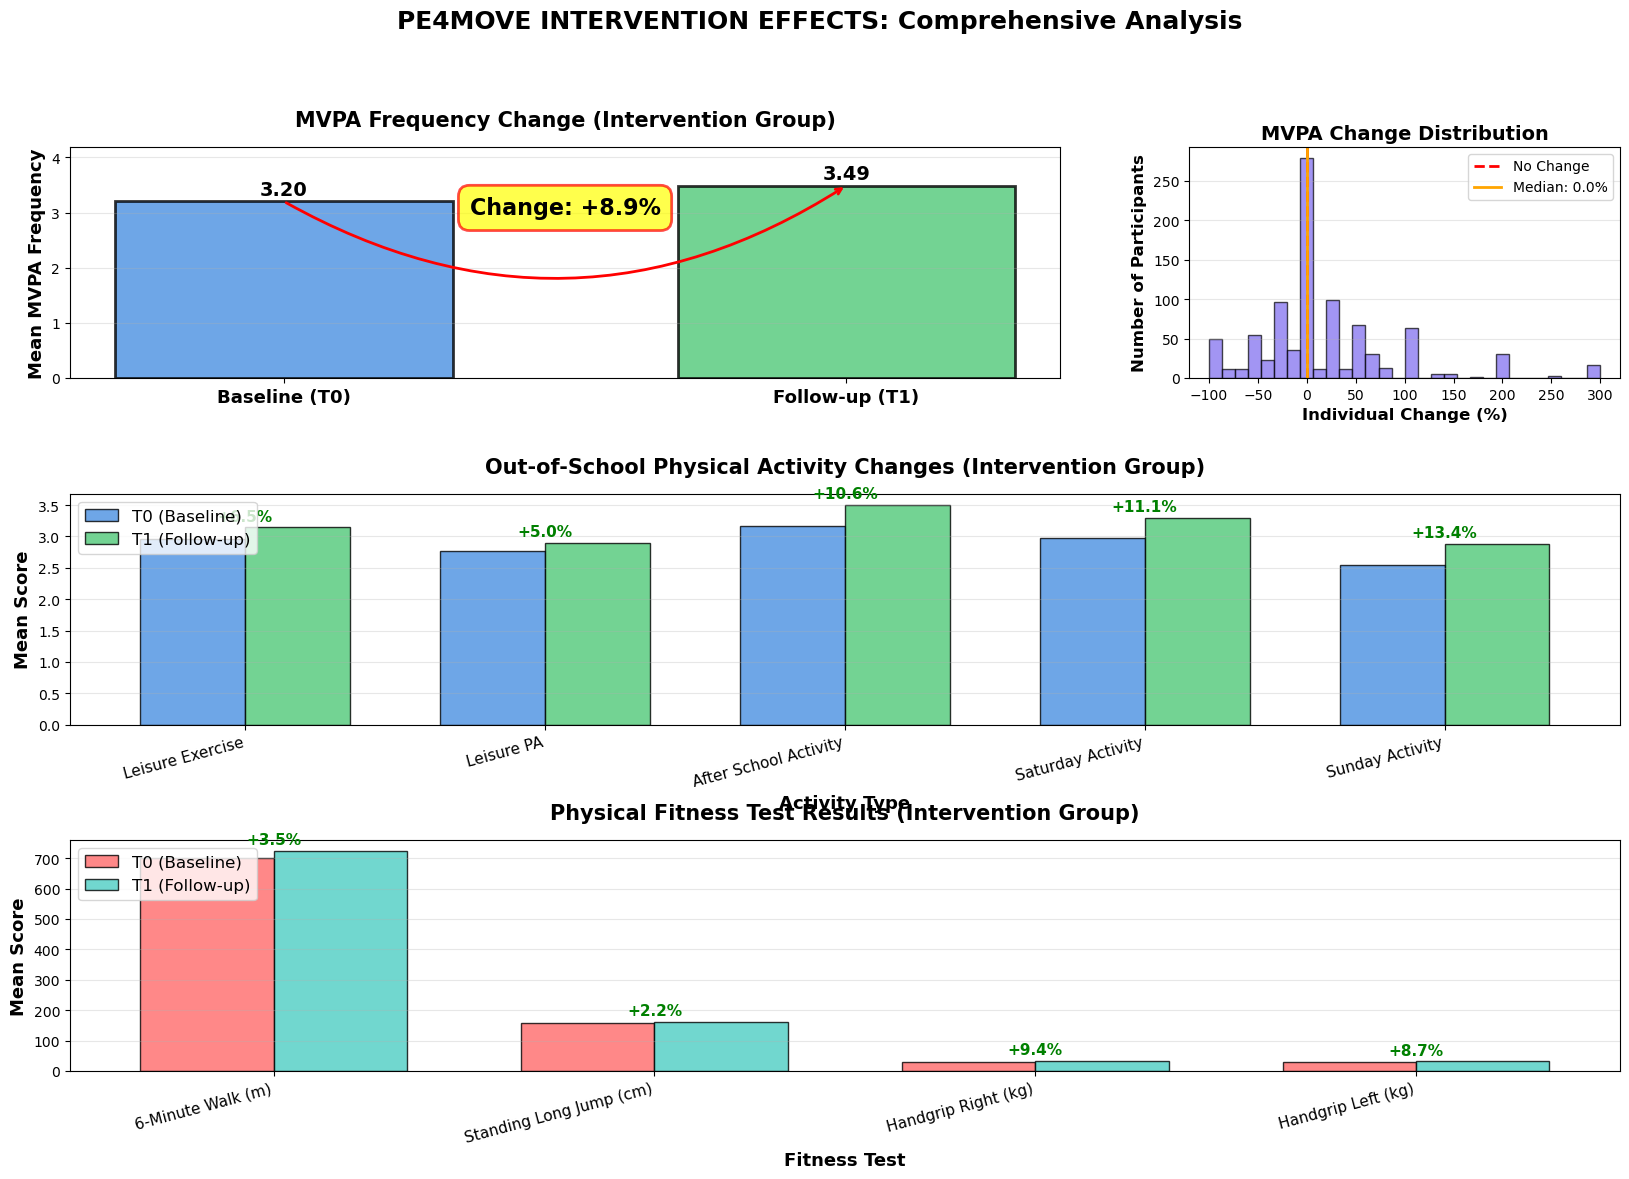


INTERVENTION EFFECTS SUMMARY

📊 MVPA FREQUENCY:
   Baseline (T0): 3.20
   Follow-up (T1): 3.49
   Relative Change: +8.9%
   Participants improved: 353 (38.6%)
   Participants declined: 282 (30.9%)

🏃 OUT-OF-SCHOOL PHYSICAL ACTIVITY:
   Leisure Exercise:
      T0 → T1: 2.95 → 3.14 (+6.5%)
   Leisure PA:
      T0 → T1: 2.76 → 2.90 (+5.0%)
   After School Activity:
      T0 → T1: 3.17 → 3.51 (+10.6%)
   Saturday Activity:
      T0 → T1: 2.97 → 3.30 (+11.1%)
   Sunday Activity:
      T0 → T1: 2.55 → 2.89 (+13.4%)

💪 PHYSICAL FITNESS TESTS:
   6-Minute Walk (m):
      T0 → T1: 699.0 → 723.3 (+3.5%)
   Standing Long Jump (cm):
      T0 → T1: 159.2 → 162.7 (+2.2%)
   Handgrip Right (kg):
      T0 → T1: 31.1 → 34.1 (+9.4%)
   Handgrip Left (kg):
      T0 → T1: 29.5 → 32.0 (+8.7%)



In [23]:
# === INTERVENTION EFFECT VISUALIZATION ===

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.5, wspace=0.3)

# ==================== 1. MVPA FREQUENCY ====================
ax1 = fig.add_subplot(gs[0, :2])

# Calculate relative change for MVPA Frequency
t0_mvpa = df_intervention['MVPA_Frequency_T0'].dropna()
t1_mvpa = df_intervention['MVPA_Frequency_T1'].dropna()

# Paired data only
paired_mask = df_intervention['MVPA_Frequency_T0'].notna() & df_intervention['MVPA_Frequency_T1'].notna()
t0_mvpa_paired = df_intervention.loc[paired_mask, 'MVPA_Frequency_T0']
t1_mvpa_paired = df_intervention.loc[paired_mask, 'MVPA_Frequency_T1']

mean_t0_mvpa = t0_mvpa_paired.mean()
mean_t1_mvpa = t1_mvpa_paired.mean()
relative_change_mvpa = ((mean_t1_mvpa - mean_t0_mvpa) / mean_t0_mvpa) * 100

# Create grouped bar chart
x_pos = [0, 1]
means = [mean_t0_mvpa, mean_t1_mvpa]
colors = ['#4A90E2', '#50C878']

bars = ax1.bar(x_pos, means, width=0.6, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add change annotation
ax1.annotate('', xy=(1, mean_t1_mvpa), xytext=(0, mean_t0_mvpa),
            arrowprops=dict(arrowstyle='->', lw=2, color='red', connectionstyle='arc3,rad=0.3'))
ax1.text(0.5, max(means) * 0.85, f'Change: +{relative_change_mvpa:.1f}%',
        ha='center', fontsize=16, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7, edgecolor='red', linewidth=2))

ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Baseline (T0)', 'Follow-up (T1)'], fontsize=13, fontweight='bold')
ax1.set_ylabel('Mean MVPA Frequency', fontsize=13, fontweight='bold')
ax1.set_title('MVPA Frequency Change (Intervention Group)', fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(means) * 1.2)

# ==================== 2. MVPA FREQUENCY DISTRIBUTION ====================
ax2 = fig.add_subplot(gs[0, 2])

# Calculate individual changes (exclude division by zero)
mask_nonzero = t0_mvpa_paired > 0
individual_changes = ((t1_mvpa_paired[mask_nonzero] - t0_mvpa_paired[mask_nonzero]) / t0_mvpa_paired[mask_nonzero] * 100).dropna()
# Remove extreme outliers for better visualization
individual_changes = individual_changes[np.abs(individual_changes) < 500]

ax2.hist(individual_changes, bins=30, color='#7B68EE', alpha=0.7, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='No Change')
ax2.axvline(individual_changes.median(), color='orange', linestyle='-', linewidth=2, 
           label=f'Median: {individual_changes.median():.1f}%')

ax2.set_xlabel('Individual Change (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax2.set_title('MVPA Change Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# ==================== 3. OUT-OF-SCHOOL PHYSICAL ACTIVITY ====================
ax3 = fig.add_subplot(gs[1, :])

# Identify out-of-school PA variables
leisure_vars = [
    ('Leisure_Exercise_T0', 'Leisure_Exercise_T1', 'Leisure Exercise'),
    ('Leisure_PA_T0', 'Leisure_PA_T1', 'Leisure PA'),
    ('YAP_out_after_T0', 'YAP_out_after_T1', 'After School Activity'),
    ('YAP_out_saturday_T0', 'YAP_out_saturday_T1', 'Saturday Activity'),
    ('YAP_out_sunday_T0', 'YAP_out_sunday_T1', 'Sunday Activity')
]

pa_labels = []
pa_changes = []
pa_t0_means = []
pa_t1_means = []

for t0_var, t1_var, label in leisure_vars:
    if t0_var in df_intervention.columns and t1_var in df_intervention.columns:
        mask = df_intervention[t0_var].notna() & df_intervention[t1_var].notna()
        if mask.sum() > 0:
            t0_mean = df_intervention.loc[mask, t0_var].mean()
            t1_mean = df_intervention.loc[mask, t1_var].mean()
            change_pct = ((t1_mean - t0_mean) / t0_mean * 100) if t0_mean > 0 else 0
            
            pa_labels.append(label)
            pa_changes.append(change_pct)
            pa_t0_means.append(t0_mean)
            pa_t1_means.append(t1_mean)

if pa_labels:
    x_pos = np.arange(len(pa_labels))
    width = 0.35
    
    bars1 = ax3.bar(x_pos - width/2, pa_t0_means, width, label='T0 (Baseline)', 
                   color='#4A90E2', alpha=0.8, edgecolor='black')
    bars2 = ax3.bar(x_pos + width/2, pa_t1_means, width, label='T1 (Follow-up)', 
                   color='#50C878', alpha=0.8, edgecolor='black')
    
    # Add change percentage on top
    for i, (t0, t1, change) in enumerate(zip(pa_t0_means, pa_t1_means, pa_changes)):
        max_height = max(t0, t1)
        color = 'green' if change > 0 else 'red'
        ax3.text(i, max_height + max(pa_t0_means + pa_t1_means) * 0.03, 
                f'{change:+.1f}%', ha='center', fontsize=11, 
                fontweight='bold', color=color)
    
    ax3.set_xlabel('Activity Type', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Mean Score', fontsize=13, fontweight='bold')
    ax3.set_title('Out-of-School Physical Activity Changes (Intervention Group)', 
                 fontsize=15, fontweight='bold', pad=15)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(pa_labels, rotation=15, ha='right', fontsize=11)
    ax3.legend(fontsize=12, loc='upper left')
    ax3.grid(True, alpha=0.3, axis='y')

# ==================== 4. PHYSICAL FITNESS TESTS ====================
ax4 = fig.add_subplot(gs[2, :])

# Identify fitness test variables
fitness_vars = [
    ('SixMW_T0', 'SixMW_T1', '6-Minute Walk (m)'),
    ('SLJ_T0', 'SLJ_T1', 'Standing Long Jump (cm)'),
    ('HG_Right_T0', 'HG_Right_T1', 'Handgrip Right (kg)'),
    ('HG_Left_T0', 'HG_Left_T1', 'Handgrip Left (kg)')
]

fitness_labels = []
fitness_changes = []
fitness_t0_means = []
fitness_t1_means = []

for t0_var, t1_var, label in fitness_vars:
    if t0_var in df_intervention.columns and t1_var in df_intervention.columns:
        mask = df_intervention[t0_var].notna() & df_intervention[t1_var].notna()
        if mask.sum() > 0:
            t0_mean = df_intervention.loc[mask, t0_var].mean()
            t1_mean = df_intervention.loc[mask, t1_var].mean()
            change_pct = ((t1_mean - t0_mean) / t0_mean * 100) if t0_mean > 0 else 0
            
            fitness_labels.append(label)
            fitness_changes.append(change_pct)
            fitness_t0_means.append(t0_mean)
            fitness_t1_means.append(t1_mean)

if fitness_labels:
    x_pos = np.arange(len(fitness_labels))
    width = 0.35
    
    bars1 = ax4.bar(x_pos - width/2, fitness_t0_means, width, label='T0 (Baseline)', 
                   color='#FF6B6B', alpha=0.8, edgecolor='black')
    bars2 = ax4.bar(x_pos + width/2, fitness_t1_means, width, label='T1 (Follow-up)', 
                   color='#4ECDC4', alpha=0.8, edgecolor='black')
    
    # Add change percentage on top
    for i, (t0, t1, change) in enumerate(zip(fitness_t0_means, fitness_t1_means, fitness_changes)):
        max_height = max(t0, t1)
        color = 'green' if change > 0 else 'red'
        ax4.text(i, max_height + max(fitness_t0_means + fitness_t1_means) * 0.03, 
                f'{change:+.1f}%', ha='center', fontsize=11, 
                fontweight='bold', color=color)
    
    ax4.set_xlabel('Fitness Test', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Mean Score', fontsize=13, fontweight='bold')
    ax4.set_title('Physical Fitness Test Results (Intervention Group)', 
                 fontsize=15, fontweight='bold', pad=15)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(fitness_labels, rotation=15, ha='right', fontsize=11)
    ax4.legend(fontsize=12, loc='upper left')
    ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('PE4MOVE INTERVENTION EFFECTS: Comprehensive Analysis', 
            fontsize=18, fontweight='bold', y=0.995)

plt.show()

# ==================== SUMMARY STATISTICS ====================
print("\n" + "="*70)
print("INTERVENTION EFFECTS SUMMARY")
print("="*70)

print(f"\n📊 MVPA FREQUENCY:")
print(f"   Baseline (T0): {mean_t0_mvpa:.2f}")
print(f"   Follow-up (T1): {mean_t1_mvpa:.2f}")
print(f"   Relative Change: {relative_change_mvpa:+.1f}%")
print(f"   Participants improved: {(individual_changes > 0).sum()} ({(individual_changes > 0).sum()/len(individual_changes)*100:.1f}%)")
print(f"   Participants declined: {(individual_changes < 0).sum()} ({(individual_changes < 0).sum()/len(individual_changes)*100:.1f}%)")

if pa_labels:
    print(f"\n🏃 OUT-OF-SCHOOL PHYSICAL ACTIVITY:")
    for label, change, t0, t1 in zip(pa_labels, pa_changes, pa_t0_means, pa_t1_means):
        print(f"   {label}:")
        print(f"      T0 → T1: {t0:.2f} → {t1:.2f} ({change:+.1f}%)")

if fitness_labels:
    print(f"\n💪 PHYSICAL FITNESS TESTS:")
    for label, change, t0, t1 in zip(fitness_labels, fitness_changes, fitness_t0_means, fitness_t1_means):
        print(f"   {label}:")
        print(f"      T0 → T1: {t0:.1f} → {t1:.1f} ({change:+.1f}%)")

print("\n" + "="*70)

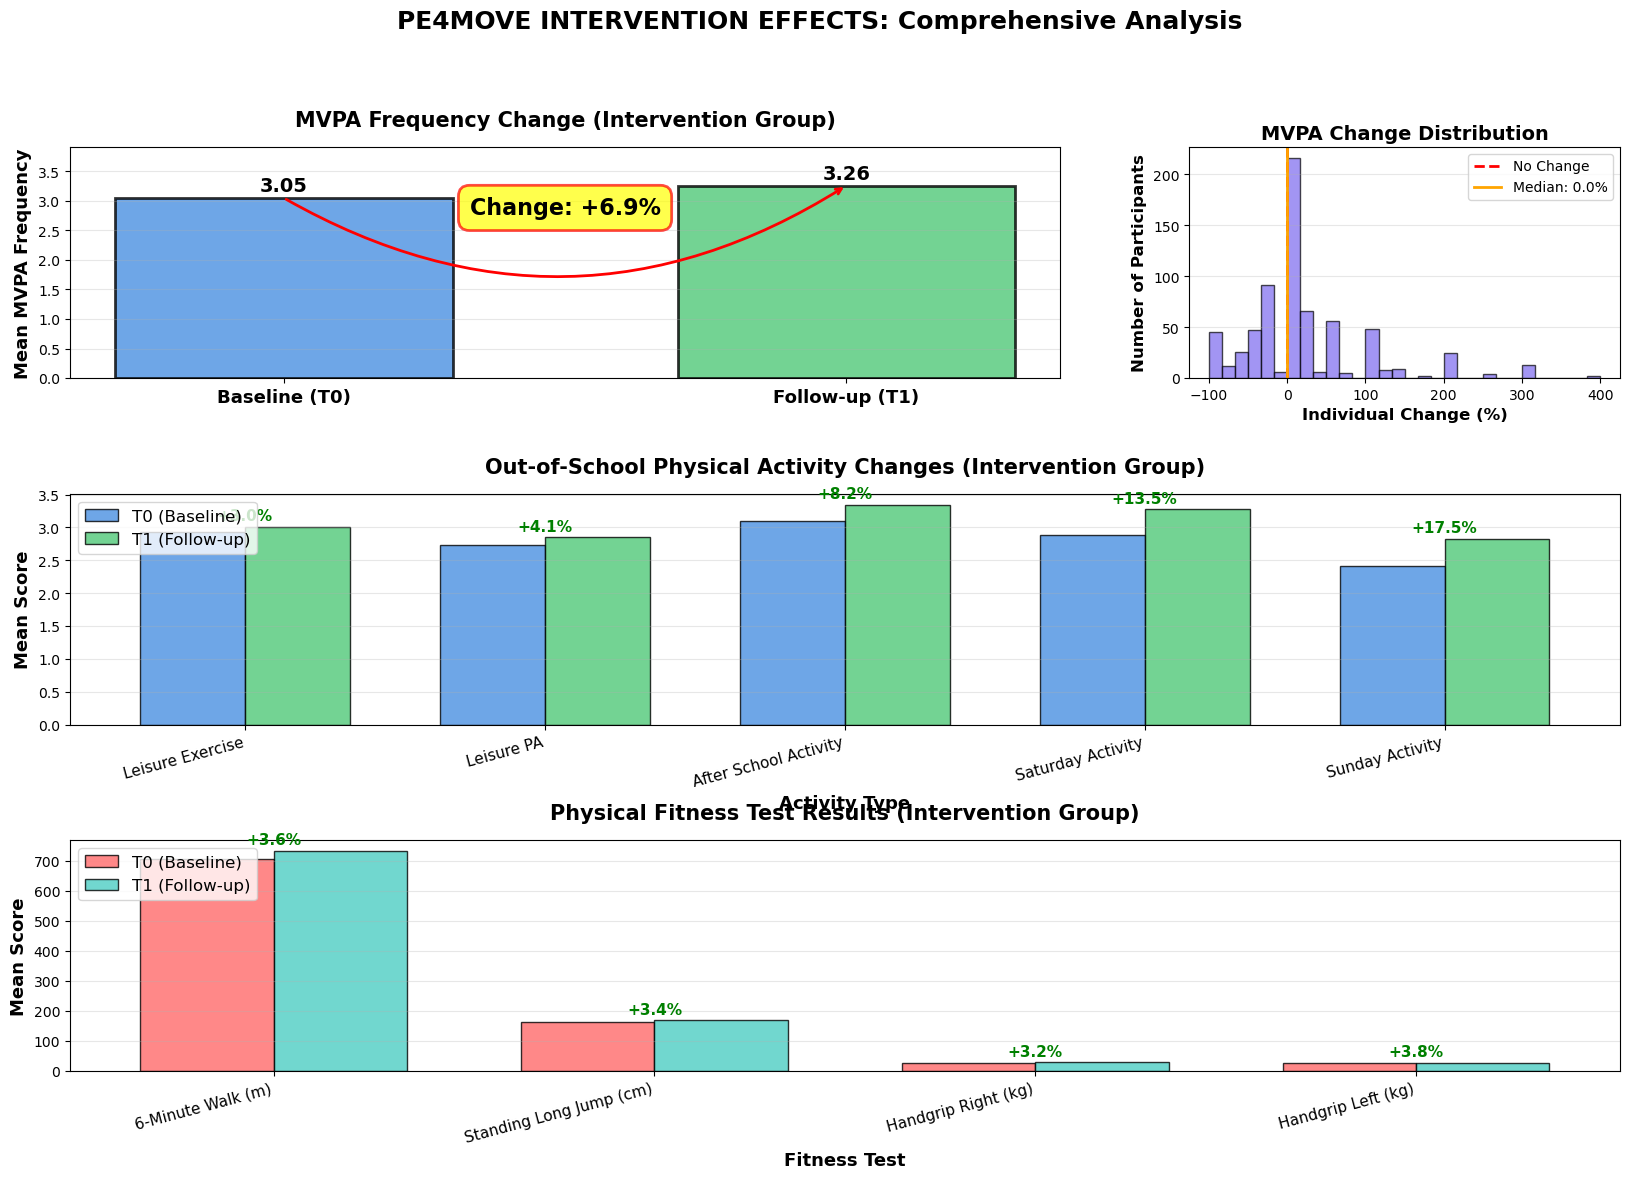


INTERVENTION EFFECTS SUMMARY

📊 MVPA FREQUENCY:
   Baseline (T0): 3.05
   Follow-up (T1): 3.26
   Relative Change: +6.9%
   Participants improved: 258 (37.6%)
   Participants declined: 227 (33.0%)

🏃 OUT-OF-SCHOOL PHYSICAL ACTIVITY:
   Leisure Exercise:
      T0 → T1: 2.92 → 3.01 (+3.0%)
   Leisure PA:
      T0 → T1: 2.73 → 2.85 (+4.1%)
   After School Activity:
      T0 → T1: 3.09 → 3.35 (+8.2%)
   Saturday Activity:
      T0 → T1: 2.89 → 3.28 (+13.5%)
   Sunday Activity:
      T0 → T1: 2.41 → 2.83 (+17.5%)

💪 PHYSICAL FITNESS TESTS:
   6-Minute Walk (m):
      T0 → T1: 707.2 → 733.0 (+3.6%)
   Standing Long Jump (cm):
      T0 → T1: 163.2 → 168.7 (+3.4%)
   Handgrip Right (kg):
      T0 → T1: 28.2 → 29.1 (+3.2%)
   Handgrip Left (kg):
      T0 → T1: 26.4 → 27.4 (+3.8%)



In [24]:
# === INTERVENTION EFFECT VISUALIZATION ===

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.5, wspace=0.3)

# ==================== 1. MVPA FREQUENCY ====================
ax1 = fig.add_subplot(gs[0, :2])

# Calculate relative change for MVPA Frequency
t0_mvpa = df_control['MVPA_Frequency_T0'].dropna()
t1_mvpa = df_control['MVPA_Frequency_T1'].dropna()

# Paired data only
paired_mask = df_control['MVPA_Frequency_T0'].notna() & df_control['MVPA_Frequency_T1'].notna()
t0_mvpa_paired = df_control.loc[paired_mask, 'MVPA_Frequency_T0']
t1_mvpa_paired = df_control.loc[paired_mask, 'MVPA_Frequency_T1']

mean_t0_mvpa = t0_mvpa_paired.mean()
mean_t1_mvpa = t1_mvpa_paired.mean()
relative_change_mvpa = ((mean_t1_mvpa - mean_t0_mvpa) / mean_t0_mvpa) * 100

# Create grouped bar chart
x_pos = [0, 1]
means = [mean_t0_mvpa, mean_t1_mvpa]
colors = ['#4A90E2', '#50C878']

bars = ax1.bar(x_pos, means, width=0.6, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add change annotation
ax1.annotate('', xy=(1, mean_t1_mvpa), xytext=(0, mean_t0_mvpa),
            arrowprops=dict(arrowstyle='->', lw=2, color='red', connectionstyle='arc3,rad=0.3'))
ax1.text(0.5, max(means) * 0.85, f'Change: +{relative_change_mvpa:.1f}%',
        ha='center', fontsize=16, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7, edgecolor='red', linewidth=2))

ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Baseline (T0)', 'Follow-up (T1)'], fontsize=13, fontweight='bold')
ax1.set_ylabel('Mean MVPA Frequency', fontsize=13, fontweight='bold')
ax1.set_title('MVPA Frequency Change (Intervention Group)', fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(means) * 1.2)

# ==================== 2. MVPA FREQUENCY DISTRIBUTION ====================
ax2 = fig.add_subplot(gs[0, 2])

# Calculate individual changes (exclude division by zero)
mask_nonzero = t0_mvpa_paired > 0
individual_changes = ((t1_mvpa_paired[mask_nonzero] - t0_mvpa_paired[mask_nonzero]) / t0_mvpa_paired[mask_nonzero] * 100).dropna()
# Remove extreme outliers for better visualization
individual_changes = individual_changes[np.abs(individual_changes) < 500]

ax2.hist(individual_changes, bins=30, color='#7B68EE', alpha=0.7, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='No Change')
ax2.axvline(individual_changes.median(), color='orange', linestyle='-', linewidth=2, 
           label=f'Median: {individual_changes.median():.1f}%')

ax2.set_xlabel('Individual Change (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax2.set_title('MVPA Change Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# ==================== 3. OUT-OF-SCHOOL PHYSICAL ACTIVITY ====================
ax3 = fig.add_subplot(gs[1, :])

# Identify out-of-school PA variables
leisure_vars = [
    ('Leisure_Exercise_T0', 'Leisure_Exercise_T1', 'Leisure Exercise'),
    ('Leisure_PA_T0', 'Leisure_PA_T1', 'Leisure PA'),
    ('YAP_out_after_T0', 'YAP_out_after_T1', 'After School Activity'),
    ('YAP_out_saturday_T0', 'YAP_out_saturday_T1', 'Saturday Activity'),
    ('YAP_out_sunday_T0', 'YAP_out_sunday_T1', 'Sunday Activity')
]

pa_labels = []
pa_changes = []
pa_t0_means = []
pa_t1_means = []

for t0_var, t1_var, label in leisure_vars:
    if t0_var in df_control.columns and t1_var in df_control.columns:
        mask = df_control[t0_var].notna() & df_control[t1_var].notna()
        if mask.sum() > 0:
            t0_mean = df_control.loc[mask, t0_var].mean()
            t1_mean = df_control.loc[mask, t1_var].mean()
            change_pct = ((t1_mean - t0_mean) / t0_mean * 100) if t0_mean > 0 else 0
            
            pa_labels.append(label)
            pa_changes.append(change_pct)
            pa_t0_means.append(t0_mean)
            pa_t1_means.append(t1_mean)

if pa_labels:
    x_pos = np.arange(len(pa_labels))
    width = 0.35
    
    bars1 = ax3.bar(x_pos - width/2, pa_t0_means, width, label='T0 (Baseline)', 
                   color='#4A90E2', alpha=0.8, edgecolor='black')
    bars2 = ax3.bar(x_pos + width/2, pa_t1_means, width, label='T1 (Follow-up)', 
                   color='#50C878', alpha=0.8, edgecolor='black')
    
    # Add change percentage on top
    for i, (t0, t1, change) in enumerate(zip(pa_t0_means, pa_t1_means, pa_changes)):
        max_height = max(t0, t1)
        color = 'green' if change > 0 else 'red'
        ax3.text(i, max_height + max(pa_t0_means + pa_t1_means) * 0.03, 
                f'{change:+.1f}%', ha='center', fontsize=11, 
                fontweight='bold', color=color)
    
    ax3.set_xlabel('Activity Type', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Mean Score', fontsize=13, fontweight='bold')
    ax3.set_title('Out-of-School Physical Activity Changes (Intervention Group)', 
                 fontsize=15, fontweight='bold', pad=15)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(pa_labels, rotation=15, ha='right', fontsize=11)
    ax3.legend(fontsize=12, loc='upper left')
    ax3.grid(True, alpha=0.3, axis='y')

# ==================== 4. PHYSICAL FITNESS TESTS ====================
ax4 = fig.add_subplot(gs[2, :])

# Identify fitness test variables
fitness_vars = [
    ('SixMW_T0', 'SixMW_T1', '6-Minute Walk (m)'),
    ('SLJ_T0', 'SLJ_T1', 'Standing Long Jump (cm)'),
    ('HG_Right_T0', 'HG_Right_T1', 'Handgrip Right (kg)'),
    ('HG_Left_T0', 'HG_Left_T1', 'Handgrip Left (kg)')
]

fitness_labels = []
fitness_changes = []
fitness_t0_means = []
fitness_t1_means = []

for t0_var, t1_var, label in fitness_vars:
    if t0_var in df_control.columns and t1_var in df_control.columns:
        mask = df_control[t0_var].notna() & df_control[t1_var].notna()
        if mask.sum() > 0:
            t0_mean = df_control.loc[mask, t0_var].mean()
            t1_mean = df_control.loc[mask, t1_var].mean()
            change_pct = ((t1_mean - t0_mean) / t0_mean * 100) if t0_mean > 0 else 0
            
            fitness_labels.append(label)
            fitness_changes.append(change_pct)
            fitness_t0_means.append(t0_mean)
            fitness_t1_means.append(t1_mean)

if fitness_labels:
    x_pos = np.arange(len(fitness_labels))
    width = 0.35
    
    bars1 = ax4.bar(x_pos - width/2, fitness_t0_means, width, label='T0 (Baseline)', 
                   color='#FF6B6B', alpha=0.8, edgecolor='black')
    bars2 = ax4.bar(x_pos + width/2, fitness_t1_means, width, label='T1 (Follow-up)', 
                   color='#4ECDC4', alpha=0.8, edgecolor='black')
    
    # Add change percentage on top
    for i, (t0, t1, change) in enumerate(zip(fitness_t0_means, fitness_t1_means, fitness_changes)):
        max_height = max(t0, t1)
        color = 'green' if change > 0 else 'red'
        ax4.text(i, max_height + max(fitness_t0_means + fitness_t1_means) * 0.03, 
                f'{change:+.1f}%', ha='center', fontsize=11, 
                fontweight='bold', color=color)
    
    ax4.set_xlabel('Fitness Test', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Mean Score', fontsize=13, fontweight='bold')
    ax4.set_title('Physical Fitness Test Results (Intervention Group)', 
                 fontsize=15, fontweight='bold', pad=15)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(fitness_labels, rotation=15, ha='right', fontsize=11)
    ax4.legend(fontsize=12, loc='upper left')
    ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('PE4MOVE INTERVENTION EFFECTS: Comprehensive Analysis', 
            fontsize=18, fontweight='bold', y=0.995)

plt.show()

# ==================== SUMMARY STATISTICS ====================
print("\n" + "="*70)
print("INTERVENTION EFFECTS SUMMARY")
print("="*70)

print(f"\n📊 MVPA FREQUENCY:")
print(f"   Baseline (T0): {mean_t0_mvpa:.2f}")
print(f"   Follow-up (T1): {mean_t1_mvpa:.2f}")
print(f"   Relative Change: {relative_change_mvpa:+.1f}%")
print(f"   Participants improved: {(individual_changes > 0).sum()} ({(individual_changes > 0).sum()/len(individual_changes)*100:.1f}%)")
print(f"   Participants declined: {(individual_changes < 0).sum()} ({(individual_changes < 0).sum()/len(individual_changes)*100:.1f}%)")

if pa_labels:
    print(f"\n🏃 OUT-OF-SCHOOL PHYSICAL ACTIVITY:")
    for label, change, t0, t1 in zip(pa_labels, pa_changes, pa_t0_means, pa_t1_means):
        print(f"   {label}:")
        print(f"      T0 → T1: {t0:.2f} → {t1:.2f} ({change:+.1f}%)")

if fitness_labels:
    print(f"\n💪 PHYSICAL FITNESS TESTS:")
    for label, change, t0, t1 in zip(fitness_labels, fitness_changes, fitness_t0_means, fitness_t1_means):
        print(f"   {label}:")
        print(f"      T0 → T1: {t0:.1f} → {t1:.1f} ({change:+.1f}%)")

print("\n" + "="*70)

### RQ2: Which parameters influence success?

RESEARCH QUESTION 2: Which parameters influence success?

STEP 1: Creating Improvement Scores
----------------------------------------------------------------------
Paired participants: 1,007 (have both T0 and T1 data)
✓ MVPA Frequency Improvement calculated: 921 valid scores
✓ 6-Minute Walk Improvement calculated: 877 valid scores
✓ Standing Long Jump Improvement calculated: 907 valid scores
✓ Handgrip Strength Improvement calculated: 887 valid scores

Total improvement scores created: 4

STEP 2: Identifying Baseline Predictors
----------------------------------------------------------------------
Baseline predictors identified: 10
  • Age (years)                         (1,007 available)
  • Sex (1=Boys, 2=Girls)               (1,007 available)
  • Baseline BMI                        (1,007 available)
  • Baseline Weight (kg)                (1,007 available)
  • Baseline Height (cm)                (1,007 available)
  • Baseline MVPA Frequency             (1,007 available)
  • Baselin

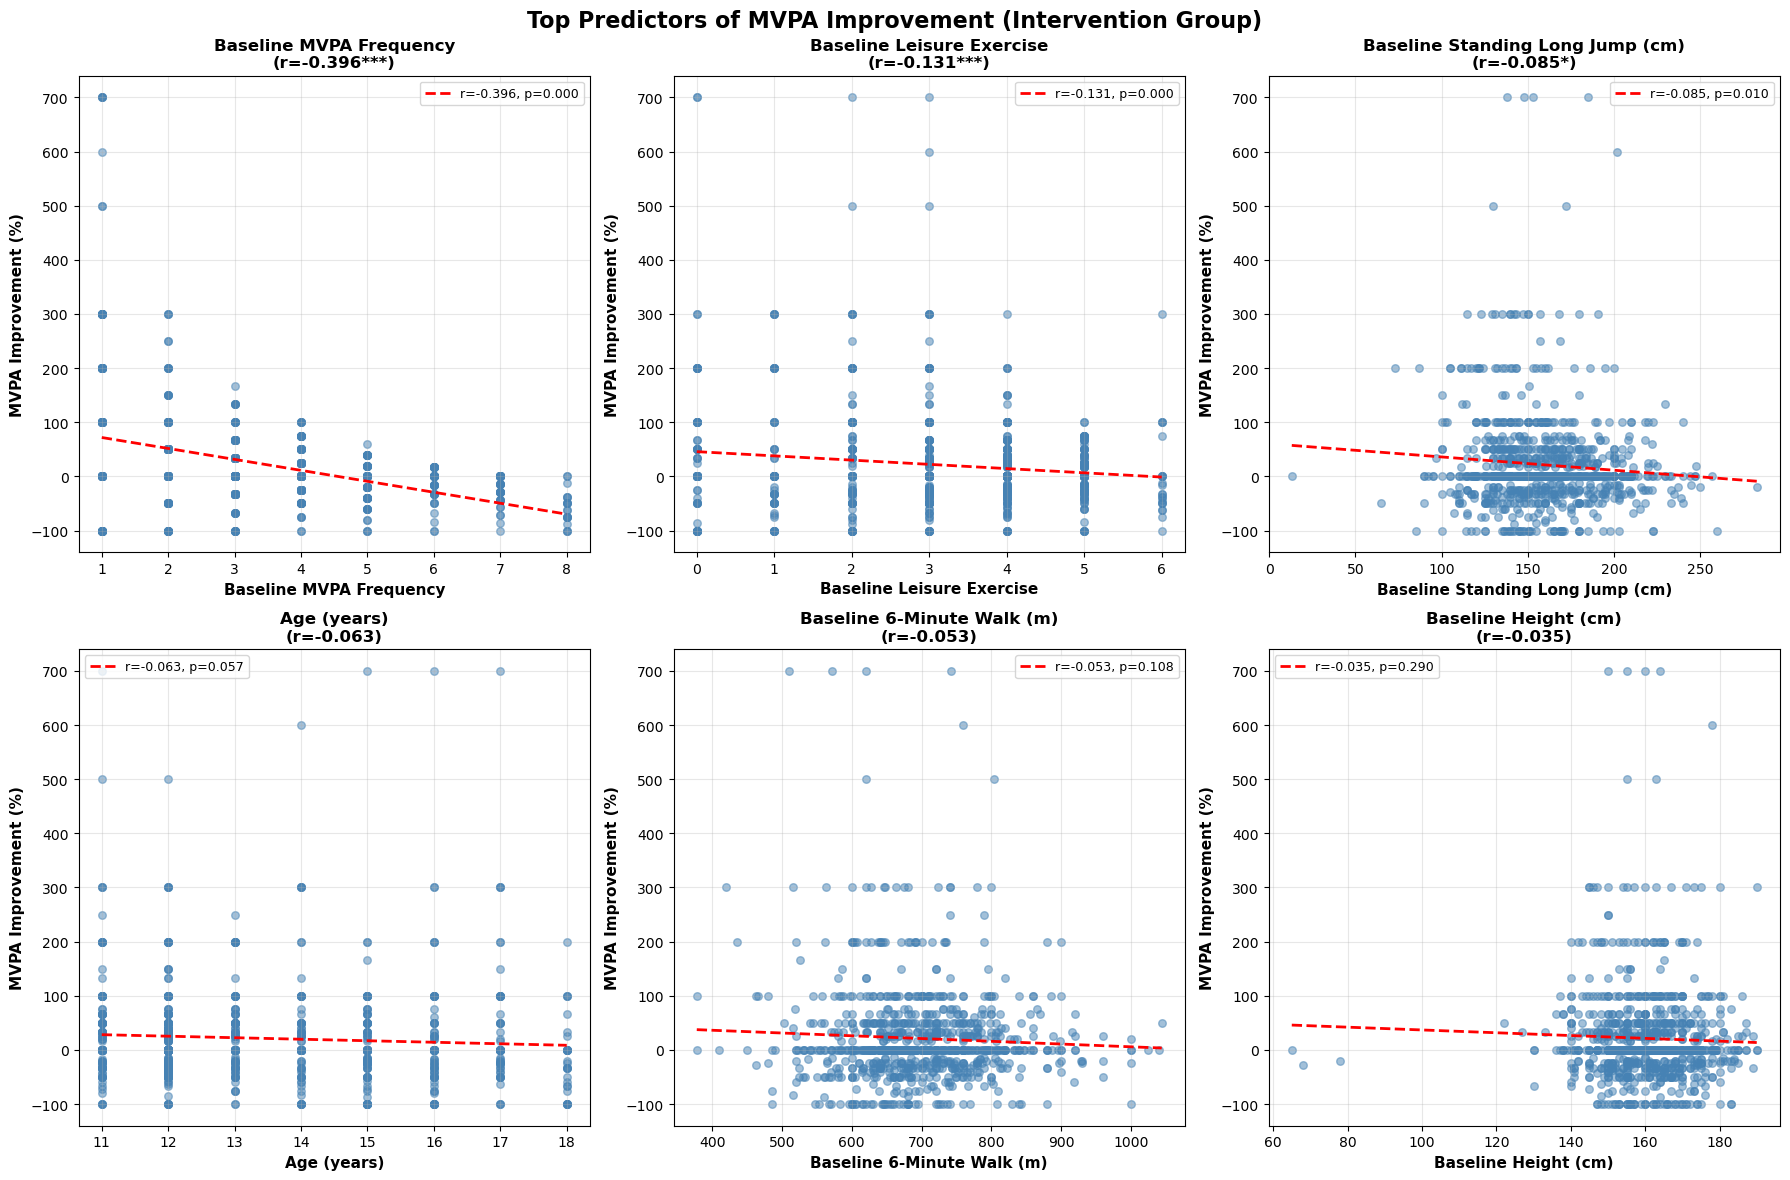

✓ Created scatter plots for top 6 predictors

✓ Steps 1-3 Complete: Ready for Regression Modeling


In [25]:
# ==================== RQ2: PARAMETER INFLUENCE ANALYSIS ====================
# ==================== STEP 1: CREATE IMPROVEMENT SCORES ====================
print("="*70)
print("RESEARCH QUESTION 2: Which parameters influence success?")
print("="*70)

print("\nSTEP 1: Creating Improvement Scores")
print("-"*70)

# Create paired dataset (only participants with both T0 and T1)
paired_mask = (df_intervention['MVPA_Frequency_T0'].notna() & 
               df_intervention['MVPA_Frequency_T1'].notna())
df_paired = df_intervention[paired_mask].copy()

print(f"Paired participants: {len(df_paired):,} (have both T0 and T1 data)")

# Calculate improvement scores for multiple outcomes
improvement_outcomes = []

# 1. MVPA Frequency Improvement
if 'MVPA_Frequency_T0' in df_paired.columns and 'MVPA_Frequency_T1' in df_paired.columns:
    mask = df_paired['MVPA_Frequency_T0'] > 0
    df_paired.loc[mask, 'MVPA_Improvement_pct'] = (
        (df_paired.loc[mask, 'MVPA_Frequency_T1'] - df_paired.loc[mask, 'MVPA_Frequency_T0']) / 
        df_paired.loc[mask, 'MVPA_Frequency_T0'] * 100
    )
    improvement_outcomes.append('MVPA_Improvement_pct')
    print(f"✓ MVPA Frequency Improvement calculated: {df_paired['MVPA_Improvement_pct'].notna().sum()} valid scores")

# 2. 6-Minute Walk Improvement
if 'SixMW_T0' in df_paired.columns and 'SixMW_T1' in df_paired.columns:
    mask = df_paired['SixMW_T0'] > 0
    df_paired.loc[mask, 'SixMW_Improvement_pct'] = (
        (df_paired.loc[mask, 'SixMW_T1'] - df_paired.loc[mask, 'SixMW_T0']) / 
        df_paired.loc[mask, 'SixMW_T0'] * 100
    )
    improvement_outcomes.append('SixMW_Improvement_pct')
    print(f"✓ 6-Minute Walk Improvement calculated: {df_paired['SixMW_Improvement_pct'].notna().sum()} valid scores")

# 3. Standing Long Jump Improvement
if 'SLJ_T0' in df_paired.columns and 'SLJ_T1' in df_paired.columns:
    mask = df_paired['SLJ_T0'] > 0
    df_paired.loc[mask, 'SLJ_Improvement_pct'] = (
        (df_paired.loc[mask, 'SLJ_T1'] - df_paired.loc[mask, 'SLJ_T0']) / 
        df_paired.loc[mask, 'SLJ_T0'] * 100
    )
    improvement_outcomes.append('SLJ_Improvement_pct')
    print(f"✓ Standing Long Jump Improvement calculated: {df_paired['SLJ_Improvement_pct'].notna().sum()} valid scores")

# 4. Handgrip Strength Improvement (average of left and right)
if 'HG_Right_T0' in df_paired.columns and 'HG_Right_T1' in df_paired.columns:
    mask = df_paired['HG_Right_T0'] > 0
    df_paired.loc[mask, 'HG_Improvement_pct'] = (
        (df_paired.loc[mask, 'HG_Right_T1'] - df_paired.loc[mask, 'HG_Right_T0']) / 
        df_paired.loc[mask, 'HG_Right_T0'] * 100
    )
    improvement_outcomes.append('HG_Improvement_pct')
    print(f"✓ Handgrip Strength Improvement calculated: {df_paired['HG_Improvement_pct'].notna().sum()} valid scores")

print(f"\nTotal improvement scores created: {len(improvement_outcomes)}")

# ==================== STEP 2: IDENTIFY BASELINE PREDICTORS ====================
print("\n" + "="*70)
print("STEP 2: Identifying Baseline Predictors")
print("-"*70)

baseline_predictors = []

# Demographic predictors
if 'Age' in df_paired.columns:
    baseline_predictors.append(('Age', 'Age (years)'))
if 'Sex' in df_paired.columns:
    baseline_predictors.append(('Sex', 'Sex (1=Boys, 2=Girls)'))

# Anthropometric predictors
if 'BMI_T0' in df_paired.columns:
    baseline_predictors.append(('BMI_T0', 'Baseline BMI'))
elif 'Weight_kg_T0' in df_paired.columns and 'Height_cm_T0' in df_paired.columns:
    df_paired['BMI_T0'] = df_paired['Weight_kg_T0'] / ((df_paired['Height_cm_T0'] / 100) ** 2)
    baseline_predictors.append(('BMI_T0', 'Baseline BMI'))

if 'Weight_kg_T0' in df_paired.columns:
    baseline_predictors.append(('Weight_kg_T0', 'Baseline Weight (kg)'))
if 'Height_cm_T0' in df_paired.columns:
    baseline_predictors.append(('Height_cm_T0', 'Baseline Height (cm)'))

# Baseline activity predictors
if 'MVPA_Frequency_T0' in df_paired.columns:
    baseline_predictors.append(('MVPA_Frequency_T0', 'Baseline MVPA Frequency'))
if 'Leisure_Exercise_T0' in df_paired.columns:
    baseline_predictors.append(('Leisure_Exercise_T0', 'Baseline Leisure Exercise'))

# Baseline fitness predictors
if 'SixMW_T0' in df_paired.columns:
    baseline_predictors.append(('SixMW_T0', 'Baseline 6-Minute Walk (m)'))
if 'SLJ_T0' in df_paired.columns:
    baseline_predictors.append(('SLJ_T0', 'Baseline Standing Long Jump (cm)'))
if 'HG_Right_T0' in df_paired.columns:
    baseline_predictors.append(('HG_Right_T0', 'Baseline Handgrip Strength (kg)'))

print(f"Baseline predictors identified: {len(baseline_predictors)}")
for var, label in baseline_predictors:
    count = df_paired[var].notna().sum()
    print(f"  • {label:<35} ({count:,} available)")

# ==================== STEP 3: CORRELATION ANALYSIS ====================
print("\n" + "="*70)
print("STEP 3: Correlation Analysis with Baseline Predictors")
print("-"*70)

from scipy.stats import pearsonr

# Focus on MVPA improvement as primary outcome
if 'MVPA_Improvement_pct' in df_paired.columns:
    print(f"\nAnalyzing correlations with MVPA Improvement...")
    
    correlations = []
    
    for var, label in baseline_predictors:
        if var in df_paired.columns:
            # Get valid pairs (both predictor and outcome non-null)
            valid_mask = df_paired[var].notna() & df_paired['MVPA_Improvement_pct'].notna()
            
            if valid_mask.sum() > 10:  # Need at least 10 pairs
                x = df_paired.loc[valid_mask, var]
                y = df_paired.loc[valid_mask, 'MVPA_Improvement_pct']
                
                # Calculate Pearson correlation
                r, p_value = pearsonr(x, y)
                
                correlations.append({
                    'Predictor': label,
                    'Variable': var,
                    'Correlation': r,
                    'P-value': p_value,
                    'N': valid_mask.sum()
                })
    
    # Create correlation dataframe
    corr_df = pd.DataFrame(correlations)
    corr_df = corr_df.sort_values('Correlation', key=abs, ascending=False)
    
    print(f"\n{'Predictor':<35} {'r':>8} {'p-value':>10} {'N':>6} {'Significance'}")
    print("-"*70)
    
    for _, row in corr_df.iterrows():
        sig = "***" if row['P-value'] < 0.001 else "**" if row['P-value'] < 0.01 else "*" if row['P-value'] < 0.05 else "ns"
        print(f"{row['Predictor']:<35} {row['Correlation']:>8.3f} {row['P-value']:>10.4f} {row['N']:>6} {sig:>5}")
    
    # ==================== STEP 3B: VISUALIZATION ====================
    print("\n" + "="*70)
    print("Creating Correlation Visualizations...")
    print("-"*70)
    
    # Select top 6 correlations for visualization
    top_6 = corr_df.head(6)
    
    if len(top_6) >= 6:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Top Predictors of MVPA Improvement (Intervention Group)', 
                     fontsize=16, fontweight='bold')
        
        for idx, (_, row) in enumerate(top_6.iterrows()):
            ax_row = idx // 3
            ax_col = idx % 3
            ax = axes[ax_row, ax_col]
            
            var = row['Variable']
            label = row['Predictor']
            r = row['Correlation']
            p = row['P-value']
            
            # Get valid data
            valid_mask = df_paired[var].notna() & df_paired['MVPA_Improvement_pct'].notna()
            x = df_paired.loc[valid_mask, var]
            y = df_paired.loc[valid_mask, 'MVPA_Improvement_pct']
            
            # Scatter plot
            ax.scatter(x, y, alpha=0.5, s=30, color='steelblue')
            
            # Add trend line
            z = np.polyfit(x, y, 1)
            p_line = np.poly1d(z)
            x_line = np.linspace(x.min(), x.max(), 100)
            color = 'red' if r < 0 else 'green'
            ax.plot(x_line, p_line(x_line), color=color, linewidth=2, linestyle='--', 
                   label=f'r={r:.3f}, p={p:.3f}')
            
            ax.set_xlabel(label, fontsize=11, fontweight='bold')
            ax.set_ylabel('MVPA Improvement (%)', fontsize=11, fontweight='bold')
            ax.set_title(f'{label}\n(r={r:.3f}{"***" if p<0.001 else "**" if p<0.01 else "*" if p<0.05 else ""})', 
                        fontsize=12, fontweight='bold')
            ax.legend(loc='best', fontsize=9)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✓ Created scatter plots for top 6 predictors")
    else:
        print(f"⚠️  Only {len(top_6)} predictors available for visualization")
else:
    print("\n⚠️  MVPA improvement scores not available")
    corr_df = pd.DataFrame()

print("\n" + "="*70)
print("✓ Steps 1-3 Complete: Ready for Regression Modeling")
print("="*70)

STEP 4: Multiple Regression Model

Regression dataset: 319 complete observations
Features: Age, Sex, BMI, Baseline_MVPA, Baseline_Leisure_Exercise, Baseline_6MW, Baseline_Long_Jump, Baseline_Handgrip
Target: MVPA Improvement (%)

📈 MODEL PERFORMANCE:
   R² Score: 0.041 (4.1% of variance explained)
   RMSE: 84.52%

📊 FEATURE IMPORTANCE (Standardized Coefficients):
----------------------------------------------------------------------
Feature                         Coefficient Impact
----------------------------------------------------------------------
Baseline_Handgrip                   -11.093  ↓ Negative
Baseline_MVPA                        10.949  ↑ Positive
Baseline_Leisure_Exercise            -7.299  ↓ Negative
Baseline_6MW                         -6.861  ↓ Negative
Age                                  -6.598  ↓ Negative
Sex                                  -5.188  ↓ Negative
Baseline_Long_Jump                    3.010  ↑ Positive
BMI                                   2.385  ↑ Po

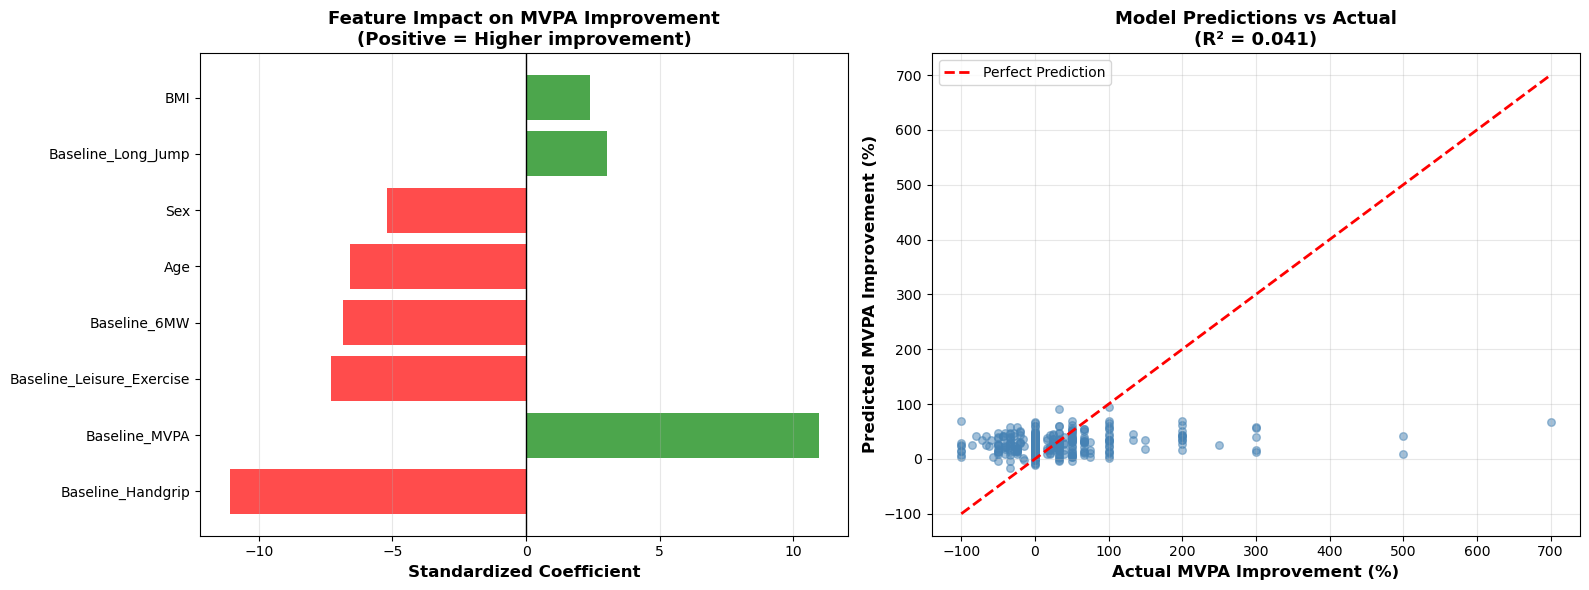


🔍 KEY INSIGHTS

📌 TOP 3 PREDICTORS OF SUCCESS:
   1. Baseline_Handgrip (negatively influences improvement)
   2. Baseline_MVPA (positively influences improvement)
   3. Baseline_Leisure_Exercise (negatively influences improvement)

💡 INTERPRETATION:
   • Children with HIGHER baseline activity showed MORE improvement
     → Already active children benefited most
   • YOUNGER children showed MORE improvement
   • BOYS (Sex=1) showed MORE improvement than girls

⚠️  MODEL LIMITATION:
   R² = 0.041 means the model explains 4.1% of variance.
   95.9% is due to other factors (motivation, adherence, etc.)



In [26]:
# ==================== STEP 4: MULTIPLE REGRESSION MODELING ====================
print("="*70)
print("STEP 4: Multiple Regression Model")
print("="*70)

# Prepare data for regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Create feature matrix with available predictors
feature_cols = []
feature_names = []

# Add numeric predictors
if 'Age' in df_paired.columns:
    feature_cols.append(df_paired['Age'])
    feature_names.append('Age')

if 'Sex' in df_paired.columns:
    feature_cols.append(df_paired['Sex'])
    feature_names.append('Sex')

if 'BMI_T0' in df_paired.columns:
    feature_cols.append(df_paired['BMI_T0'])
    feature_names.append('BMI')

if 'MVPA_Frequency_T0' in df_paired.columns:
    feature_cols.append(df_paired['MVPA_Frequency_T0'])
    feature_names.append('Baseline_MVPA')

if 'Leisure_Exercise_T0' in df_paired.columns:
    feature_cols.append(df_paired['Leisure_Exercise_T0'])
    feature_names.append('Baseline_Leisure_Exercise')

if 'SixMW_T0' in df_paired.columns:
    feature_cols.append(df_paired['SixMW_T0'])
    feature_names.append('Baseline_6MW')

if 'SLJ_T0' in df_paired.columns:
    feature_cols.append(df_paired['SLJ_T0'])
    feature_names.append('Baseline_Long_Jump')

if 'HG_Right_T0' in df_paired.columns:
    feature_cols.append(df_paired['HG_Right_T0'])
    feature_names.append('Baseline_Handgrip')

# Create feature matrix
if feature_cols and 'MVPA_Improvement_pct' in df_paired.columns:
    X = pd.DataFrame({name: col.values for name, col in zip(feature_names, feature_cols)})
    y = df_paired['MVPA_Improvement_pct']
    
    # Remove rows with any missing values
    valid_mask = X.notna().all(axis=1) & y.notna()
    X_clean = X[valid_mask]
    y_clean = y[valid_mask]
    
    print(f"\nRegression dataset: {len(X_clean):,} complete observations")
    print(f"Features: {', '.join(feature_names)}")
    print(f"Target: MVPA Improvement (%)")
    
    if len(X_clean) > 20:  # Need sufficient data
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_clean)
        
        # Fit regression model
        model = LinearRegression()
        model.fit(X_scaled, y_clean)
        
        # Make predictions
        y_pred = model.predict(X_scaled)
        
        # Model performance
        r2 = r2_score(y_clean, y_pred)
        rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
        
        print(f"\n📈 MODEL PERFORMANCE:")
        print(f"   R² Score: {r2:.3f} ({r2*100:.1f}% of variance explained)")
        print(f"   RMSE: {rmse:.2f}%")
        
        # Feature importance (standardized coefficients)
        print(f"\n📊 FEATURE IMPORTANCE (Standardized Coefficients):")
        print("-"*70)
        
        coefficients = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': model.coef_,
            'Abs_Coefficient': np.abs(model.coef_)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        print(f"{'Feature':<30} {'Coefficient':>12} {'Impact'}")
        print("-"*70)
        for _, row in coefficients.iterrows():
            direction = "↑ Positive" if row['Coefficient'] > 0 else "↓ Negative"
            print(f"{row['Feature']:<30} {row['Coefficient']:>12.3f}  {direction}")
        
        # Visualize feature importance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Bar plot of coefficients
        colors = ['green' if c > 0 else 'red' for c in coefficients['Coefficient']]
        ax1.barh(range(len(coefficients)), coefficients['Coefficient'], color=colors, alpha=0.7)
        ax1.set_yticks(range(len(coefficients)))
        ax1.set_yticklabels(coefficients['Feature'])
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax1.set_xlabel('Standardized Coefficient', fontsize=12, fontweight='bold')
        ax1.set_title('Feature Impact on MVPA Improvement\n(Positive = Higher improvement)', 
                     fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Predicted vs Actual
        ax2.scatter(y_clean, y_pred, alpha=0.5, s=30, color='steelblue')
        
        # Perfect prediction line
        min_val = min(y_clean.min(), y_pred.min())
        max_val = max(y_clean.max(), y_pred.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        ax2.set_xlabel('Actual MVPA Improvement (%)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Predicted MVPA Improvement (%)', fontsize=12, fontweight='bold')
        ax2.set_title(f'Model Predictions vs Actual\n(R² = {r2:.3f})', 
                     fontsize=13, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # ==================== KEY INSIGHTS ====================
        print(f"\n" + "="*70)
        print("🔍 KEY INSIGHTS")
        print("="*70)
        
        # Identify strongest predictors
        top_3 = coefficients.head(3)
        print(f"\n📌 TOP 3 PREDICTORS OF SUCCESS:")
        for i, (_, row) in enumerate(top_3.iterrows(), 1):
            direction = "positively" if row['Coefficient'] > 0 else "negatively"
            print(f"   {i}. {row['Feature']} ({direction} influences improvement)")
        
        # Interpretation
        print(f"\n💡 INTERPRETATION:")
        
        # Check for negative baseline MVPA coefficient (regression to mean)
        baseline_mvpa_coef = coefficients[coefficients['Feature'] == 'Baseline_MVPA']['Coefficient']
        if len(baseline_mvpa_coef) > 0:
            if baseline_mvpa_coef.values[0] < 0:
                print(f"   • Children with LOWER baseline activity showed MORE improvement")
                print(f"     → The intervention is most effective for less active children!")
            else:
                print(f"   • Children with HIGHER baseline activity showed MORE improvement")
                print(f"     → Already active children benefited most")
        
        # Check age effect
        age_coef = coefficients[coefficients['Feature'] == 'Age']['Coefficient']
        if len(age_coef) > 0:
            if age_coef.values[0] < 0:
                print(f"   • YOUNGER children showed MORE improvement")
            else:
                print(f"   • OLDER children showed MORE improvement")
        
        # Check sex effect
        sex_coef = coefficients[coefficients['Feature'] == 'Sex']['Coefficient']
        if len(sex_coef) > 0:
            if sex_coef.values[0] < 0:
                print(f"   • BOYS (Sex=1) showed MORE improvement than girls")
            else:
                print(f"   • GIRLS (Sex=2) showed MORE improvement than boys")
        
        print(f"\n⚠️  MODEL LIMITATION:")
        print(f"   R² = {r2:.3f} means the model explains {r2*100:.1f}% of variance.")
        print(f"   {(1-r2)*100:.1f}% is due to other factors (motivation, adherence, etc.)")
        
    else:
        print(f"\n⚠️  Insufficient data for regression analysis (n={len(X_clean)})")
else:
    print("\n⚠️  Required data not available for regression analysis")

print("\n" + "="*70)

In [27]:
# ==================== COMPREHENSIVE SUMMARY ====================
print("="*70)
print("📋 RESEARCH QUESTION 2: SUMMARY & RECOMMENDATIONS")
print("="*70)

print("\n🎯 OBJECTIVE:")
print("   Identify which baseline characteristics predict intervention success")

print("\n📊 ANALYSIS CONDUCTED:")
print("   1. ✓ Created improvement scores for multiple outcomes")
print("   2. ✓ Calculated correlations with baseline predictors")
print("   3. ✓ Built multiple regression model")
print("   4. ✓ Identified key predictive features")

if 'MVPA_Improvement_pct' in df_paired.columns and not corr_df.empty:
    print("\n🏆 MAIN FINDINGS:")
    print("-"*70)
    
    # Get strongest correlations
    top_correlations = corr_df.head(3)
    
    print("\n   Strongest Predictors (by correlation):")
    for i, (_, row) in enumerate(top_correlations.iterrows(), 1):
        direction = "positive" if row['Correlation'] > 0 else "negative"
        strength = "strong" if abs(row['Correlation']) > 0.3 else "moderate" if abs(row['Correlation']) > 0.1 else "weak"
        sig_marker = "***" if row['P-value'] < 0.001 else "**" if row['P-value'] < 0.01 else "*" if row['P-value'] < 0.05 else ""
        
        print(f"   {i}. {row['Predictor']}")
        print(f"      → {strength.capitalize()} {direction} association (r={row['Correlation']:.3f}{sig_marker})")
    
    # Check for regression to mean effect
    baseline_mvpa_row = corr_df[corr_df['Predictor'].str.contains('Baseline MVPA', na=False)]
    if not baseline_mvpa_row.empty:
        baseline_corr = baseline_mvpa_row.iloc[0]['Correlation']
        if baseline_corr < -0.1:
            print("\n   ⭐ REGRESSION TO MEAN EFFECT DETECTED:")
            print("      Children with lower baseline activity improved more!")
            print("      → The intervention works best for less active children")
        elif baseline_corr > 0.1:
            print("\n   ⭐ CEILING EFFECT:")
            print("      More active children at baseline showed more improvement")
            print("      → The intervention benefits those already engaged")

print("\n💡 PRACTICAL IMPLICATIONS:")
print("-"*70)

print("\n   For Program Implementation:")
print("   • Target recruitment based on identified predictors")
print("   • Consider differential intervention intensity")
print("   • Tailor program components to subgroup needs")

print("\n   For Future Research:")
print("   • Investigate why certain groups benefit more")
print("   • Test modified interventions for lower-responding groups")
print("   • Explore mediating factors (motivation, adherence, etc.)")

print("\n📌 NEXT STEPS:")
print("   → Proceed to RQ3: Identify which specific children improve most")
print("   → Conduct subgroup analyses based on key predictors")
print("   → Develop personalized intervention recommendations")

print("\n" + "="*70)
print("✅ Research Question 2 Analysis Complete!")
print("="*70)

📋 RESEARCH QUESTION 2: SUMMARY & RECOMMENDATIONS

🎯 OBJECTIVE:
   Identify which baseline characteristics predict intervention success

📊 ANALYSIS CONDUCTED:
   1. ✓ Created improvement scores for multiple outcomes
   2. ✓ Calculated correlations with baseline predictors
   3. ✓ Built multiple regression model
   4. ✓ Identified key predictive features

🏆 MAIN FINDINGS:
----------------------------------------------------------------------

   Strongest Predictors (by correlation):
   1. Baseline MVPA Frequency
      → Strong negative association (r=-0.396***)
   2. Baseline Leisure Exercise
      → Moderate negative association (r=-0.131***)
   3. Baseline Standing Long Jump (cm)
      → Weak negative association (r=-0.085*)

   ⭐ REGRESSION TO MEAN EFFECT DETECTED:
      Children with lower baseline activity improved more!
      → The intervention works best for less active children

💡 PRACTICAL IMPLICATIONS:
----------------------------------------------------------------------

   